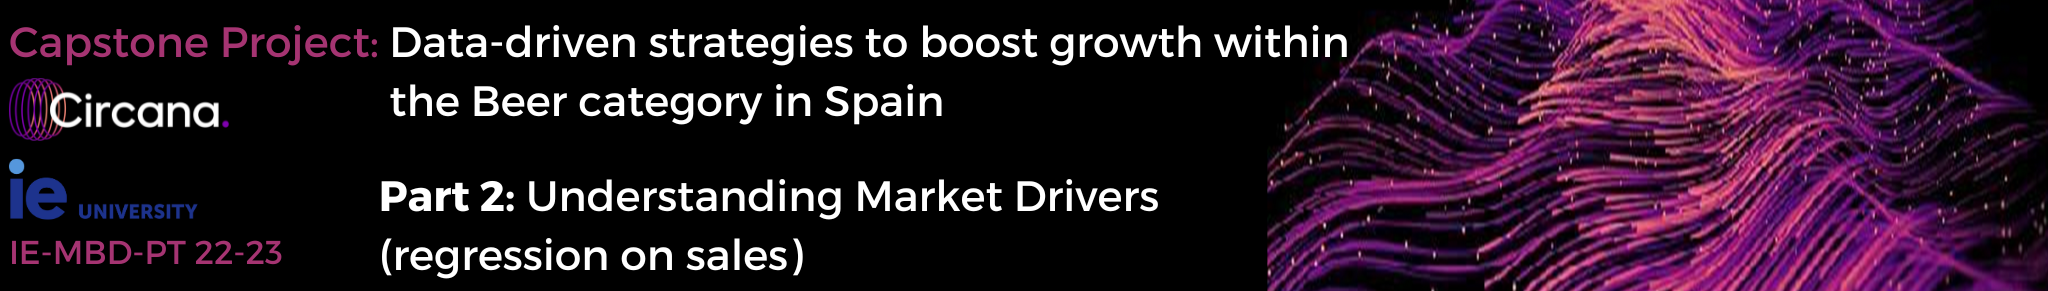

In [1]:
from IPython.display import Image
Image(filename='images/header-part2.png')

The purpose of this notebook is to carry out a **regression algorythm to identify market drivers for sales**. As a first step will try different regression models to identfy the best suited for the data, once this has been decided based on the R squared score. The resulting feature importance of the model chosen will indicate what are the man drivers for the market sales.

## <span style="color: purple">**Table of contents**</span> <a class="anchor"></a>
- [<span style="color: purple">0. Preparing the environment</span>](#section_0)
- [<span style="color: purple">1. Feature Engineering</span>](#section_1)
- [<span style="color: purple">2. Checking for correlation</span>](#section_2)
    - [<span style="color: purple">2.1. Correlation Matrix</span>](#section_2_1)
- [<span style="color: purple">3. Data Preparation</span>](#section_3)
    - [<span style="color: purple">3.1. Outliers</span>](#section_3_1)
- [<span style="color: purple">4. Prediction model</span>](#section_4)
    - [<span style="color: purple">4.1. Splitting the dataset</span>](#section_4_1)
    - [<span style="color: purple">4.2. Linear Regression</span>](#section_4_2)
    - [<span style="color: purple">4.3. Random Forest</span>](#section_4_3)
    - [<span style="color: purple">4.4. XGBoost</span>](#section_4_4)
    - [<span style="color: purple">4.5. Creating functions to run the XGboost steps for the following regressions</span>](#section_4_5)
- [<span style="color: purple">5. Improving the XGBoost Model</span>](#section_5)
- [<span style="color: purple">6. Drivers for top 3 Manufacturers</span>](#section_6)
    - [<span style="color: purple">6.1. Manufacturer 3: Drivers for sales</span>](#section_6_1)
    - [<span style="color: purple">6.2. Manufacturer 2: Drivers for sales</span>](#section_6_2)
    - [<span style="color: purple">6.3. Manufacturer 6: Drivers for sales</span>](#section_6_3)
    - [<span style="color: purple">6.4. Comparing Drivers for top 3 Manufacturers</span>](#section_6_4)



## <span style="color: purple">**0. Preparing the environment**</span> <a class="anchor" id="section_0"></a>

In [61]:
#!pip install lime

In [3]:
#Importing the needed libraries
import time
from datetime import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Source

from sklearn import tree, ensemble
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    r2_score
    )

from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from xgboost import XGBRegressor

import squarify

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
circana = pd.read_csv('datasets/circana_data.csv')

Creating a copy in case the file needs to be restored while running the notebook.

In [64]:
circana_copy = circana.copy()
#circana = circana_copy.copy()

## <span style="color: purple">**1. Feature Engineering**</span> <a class="anchor" id="section_1"></a>

On this section, we will perform a really high level EDA (as most of the relevant analysis has been covered in Part 1) and some easy feature engineering (we start with some feature preparation, feature creation and feature selection) to prepare the data for the regression models.

In [65]:
circana_columns = circana.columns
print(circana_columns)

Index(['Store Code', 'Week Code', 'Product Code', 'Sales in units',
       'Sales in value (€)', 'Sales in volume (Lt)', 'Number of references',
       'Real price in units', 'Real price in volume', 'Rate price in units',
       'Rate price in volume', 'Month', 'Year', 'Season', 'Quarter',
       'channel_code', 'province code', 'postal_code',
       'sales_surface_sqmeters', 'Province', 'Autonomus Community', 'Channel',
       'SEGMENT', 'MANUFACTURER', 'BRAND', 'PACKAGING', 'VOLUME', 'UNITS',
       'min temp', 'max temp', 'mean temp', 'precipitation', 'promotion',
       'holiday', 'population', 'liters/person'],
      dtype='object')


Number of references will be dropped as it is a unique number that does not contribute to the analysis. 

In [66]:
circana.dtypes

Store Code                  int64
Week Code                   int64
Product Code                int64
Sales in units              int64
Sales in value (€)        float64
Sales in volume (Lt)        int64
Number of references        int64
Real price in units       float64
Real price in volume      float64
Rate price in units       float64
Rate price in volume      float64
Month                       int64
Year                        int64
Season                     object
Quarter                     int64
channel_code                int64
province code               int64
postal_code                 int64
sales_surface_sqmeters      int64
Province                   object
Autonomus Community        object
Channel                    object
SEGMENT                    object
MANUFACTURER               object
BRAND                      object
PACKAGING                  object
VOLUME                      int64
UNITS                       int64
min temp                  float64
max temp      

In [67]:
#droppin not needed columns
circana = circana.drop(['Channel', 'Autonomus Community','BRAND','Number of references'], axis=1)

Holiday variable is turned into a boolean as from the preliminary exploration it was taking different values. 

In [68]:
circana['holiday'] = circana['holiday'].apply(lambda x: 1 if x != 0 else 0)

The Liters consumed per person is grouped by Province and Year to reflect the amount of Liters consumed by the population in the year.

In [69]:
#group liter/person by 'Province' and 'Year'	
circana['liters/person'] = circana.groupby(['Province', 'Year'])['liters/person'].transform('sum')

In [70]:
#describe liters/person
print(circana['liters/person'].describe())

count    5.547705e+06
mean     5.517717e+00
std      4.796616e+00
min      1.196296e-02
25%      2.339586e+00
50%      4.423856e+00
75%      5.471996e+00
max      1.744564e+01
Name: liters/person, dtype: float64


In [71]:
#We also drop the variable called 'Province'
circana = circana.drop(['Province'], axis=1)

checking the shape of the data frame.

In [72]:
circana.head()

Store Code  Week Code  Product Code  Sales in units  Sales in value (€)  \
0         243         42           236              30               19.50   
1         243        108           236              17               11.05   
2         243         68           236               9                4.95   
3         243         11           236              33               15.84   
4         243         49           236               3                1.95   

   Sales in volume (Lt)  Real price in units  Real price in volume  \
0                    10                 0.65                  0.33   
1                     6                 0.65                  0.33   
2                     3                 0.55                  0.33   
3                    11                 0.48                  0.33   
4                     1                 0.65                  0.33   

   Rate price in units  Rate price in volume  Month  Year  Season  Quarter  \
0                 0.65                  0.33     10  2021  Autumn        4   
1                 0.65                  0.33      1  2023  Winter        1   
2                 0.55                  0.33      4  2022  Spring        2   
3                 0.65                  0.33      3  2021  Spring        1   
4                 0.65                  0.33     12  2021  Winter        4   

   channel_code  province code  postal_code  sales_surface_sqmeters SEGMENT  \
0             1             26        26003                    1500   EXTRA   
1             1             26        26003                    1500   EXTRA   
2             1             26        26003                    1500   EXTRA   
3             1             26        26003                    1500   EXTRA   
4             1             26        26003                    1500   EXTRA   

     MANUFACTURER PACKAGING  VOLUME  UNITS  min temp   max temp  mean temp  \
0  MANUFACTURER 2       CAN     330      1  5.671429  12.285714   8.800000   
1  MANUFACTURER 2       CAN     330      1  2.971429  10.471429   6.671429   
2  MANUFACTURER 2       CAN     330      1  9.600000  21.542857  15.500000   
3  MANUFACTURER 2       CAN     330      1  4.142857  12.442857   8.114286   
4  MANUFACTURER 2       CAN     330      1 -0.042857   6.842857   2.600000   

   precipitation        promotion  holiday  population  liters/person  
0       1.285714             None        0      241713       1.842685  
1       1.800000             None        0      241713       0.358632  
2       1.771429             None        1      241713       1.924468  
3       2.785714  Promo descuento        1      241713       1.842685  
4       0.071429             None        1      241713       1.842685

## <span style="color: purple">**2. Checking for correlations**</span> <a class="anchor" id="section_2"></a>

Before running any model it is important to check correlations between the different variables in order do avoid milticolinearity.

The **target variable** for this notebook will be **Sales in Value (€)** so as a first step we wil check the correlation of the numeric variables with the target. 

In [73]:
circana.corr()[['Sales in value (€)']].sort_values('Sales in value (€)')

C:\Users\JuanHorrillo\AppData\Local\Temp\ipykernel_40152\3058420258.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  circana.corr()[['Sales in value (€)']].sort_values('Sales in value (€)')


Sales in value (€)
precipitation                    -0.017863
postal_code                      -0.010456
VOLUME                           -0.009553
Week Code                        -0.005895
Year                             -0.004967
Quarter                          -0.002683
holiday                          -0.002224
Month                            -0.001366
province code                     0.004098
population                        0.005942
Store Code                        0.007324
Product Code                      0.024070
min temp                          0.024694
mean temp                         0.030037
max temp                          0.033785
liters/person                     0.042415
channel_code                      0.092930
sales_surface_sqmeters            0.099403
Real price in units               0.152674
Rate price in units               0.175873
UNITS                             0.226373
Rate price in volume              0.237312
Real price in volume              0.237312
Sales in units                    0.555218
Sales in volume (Lt)              0.931561
Sales in value (€)                1.000000

Some variables are positevely correlated with the target variable and some are negatively.  Additionally, some will need to be dropped due to their high correlation with the target.

## <span style="color: purple">2.1 Correlation Matrix</span> <a class="anchor" id="section_2_1"></a>

Plotting the correlation matrix for the numeric variables to graphically check the correlations. 

C:\Users\JuanHorrillo\AppData\Local\Temp\ipykernel_40152\3739545125.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(circana.corr(), annot=True, cmap='coolwarm')


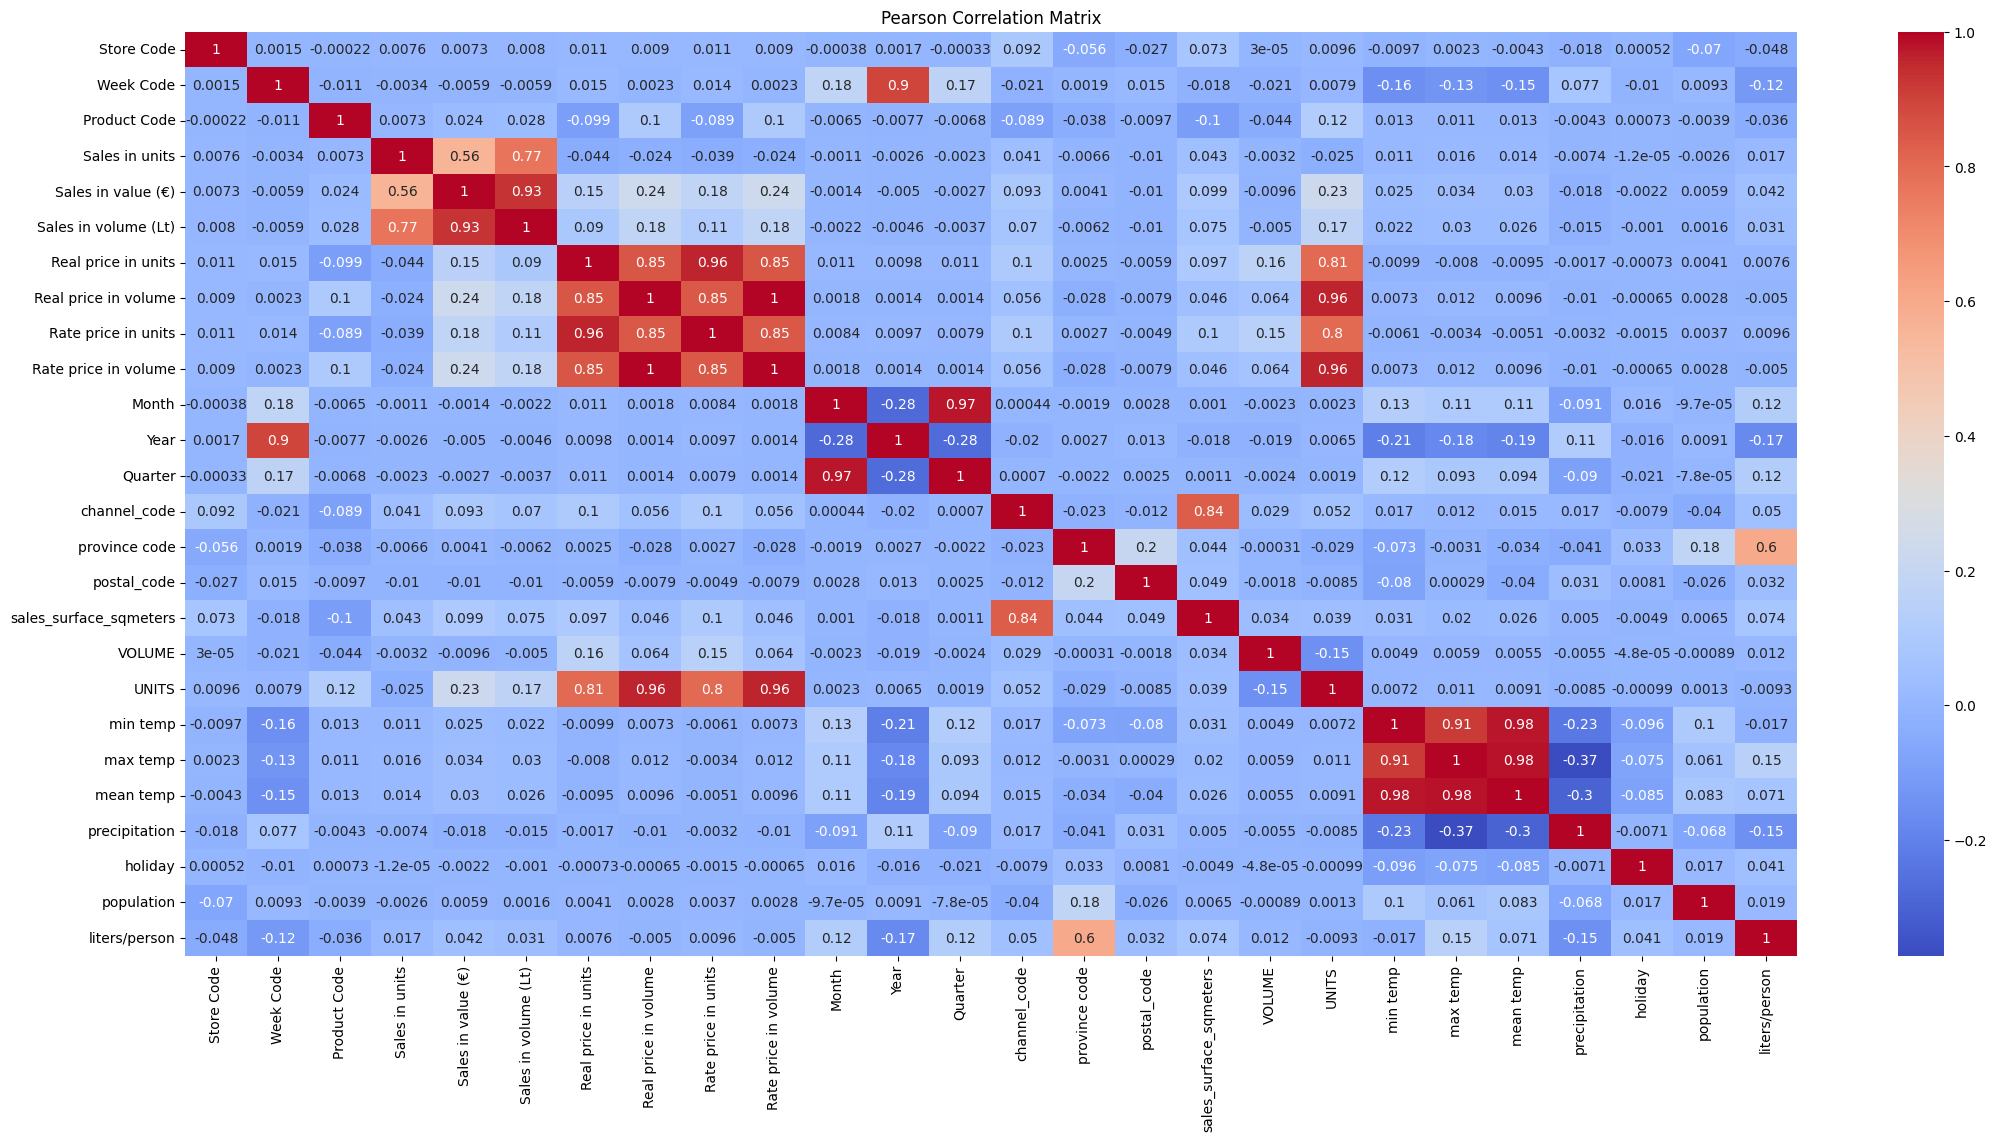

In [74]:
#Plot the correlation matrix as a heatmap
plt.figure(figsize=(26, 12))
sns.heatmap(circana.corr(), annot=True, cmap='coolwarm')
plt.title('Pearson Correlation Matrix')
plt.show()

In [75]:
circana_columns = circana.columns
print(circana_columns)

Index(['Store Code', 'Week Code', 'Product Code', 'Sales in units',
       'Sales in value (€)', 'Sales in volume (Lt)', 'Real price in units',
       'Real price in volume', 'Rate price in units', 'Rate price in volume',
       'Month', 'Year', 'Season', 'Quarter', 'channel_code', 'province code',
       'postal_code', 'sales_surface_sqmeters', 'SEGMENT', 'MANUFACTURER',
       'PACKAGING', 'VOLUME', 'UNITS', 'min temp', 'max temp', 'mean temp',
       'precipitation', 'promotion', 'holiday', 'population', 'liters/person'],
      dtype='object')


Now, we will drop the variables that were identfied to have a high correlation with the target 

In [76]:
circana = circana.drop(['Year','Real price in units','Rate price in units','Rate price in volume','UNITS','Month',
                        'Quarter', 'sales_surface_sqmeters','min temp', 'max temp','province code','Sales in volume (Lt)'], axis=1)

Checking correlation matrix again after dropping the variables.

C:\Users\JuanHorrillo\AppData\Local\Temp\ipykernel_40152\3731980572.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(circana.corr(), annot=True, cmap='coolwarm')


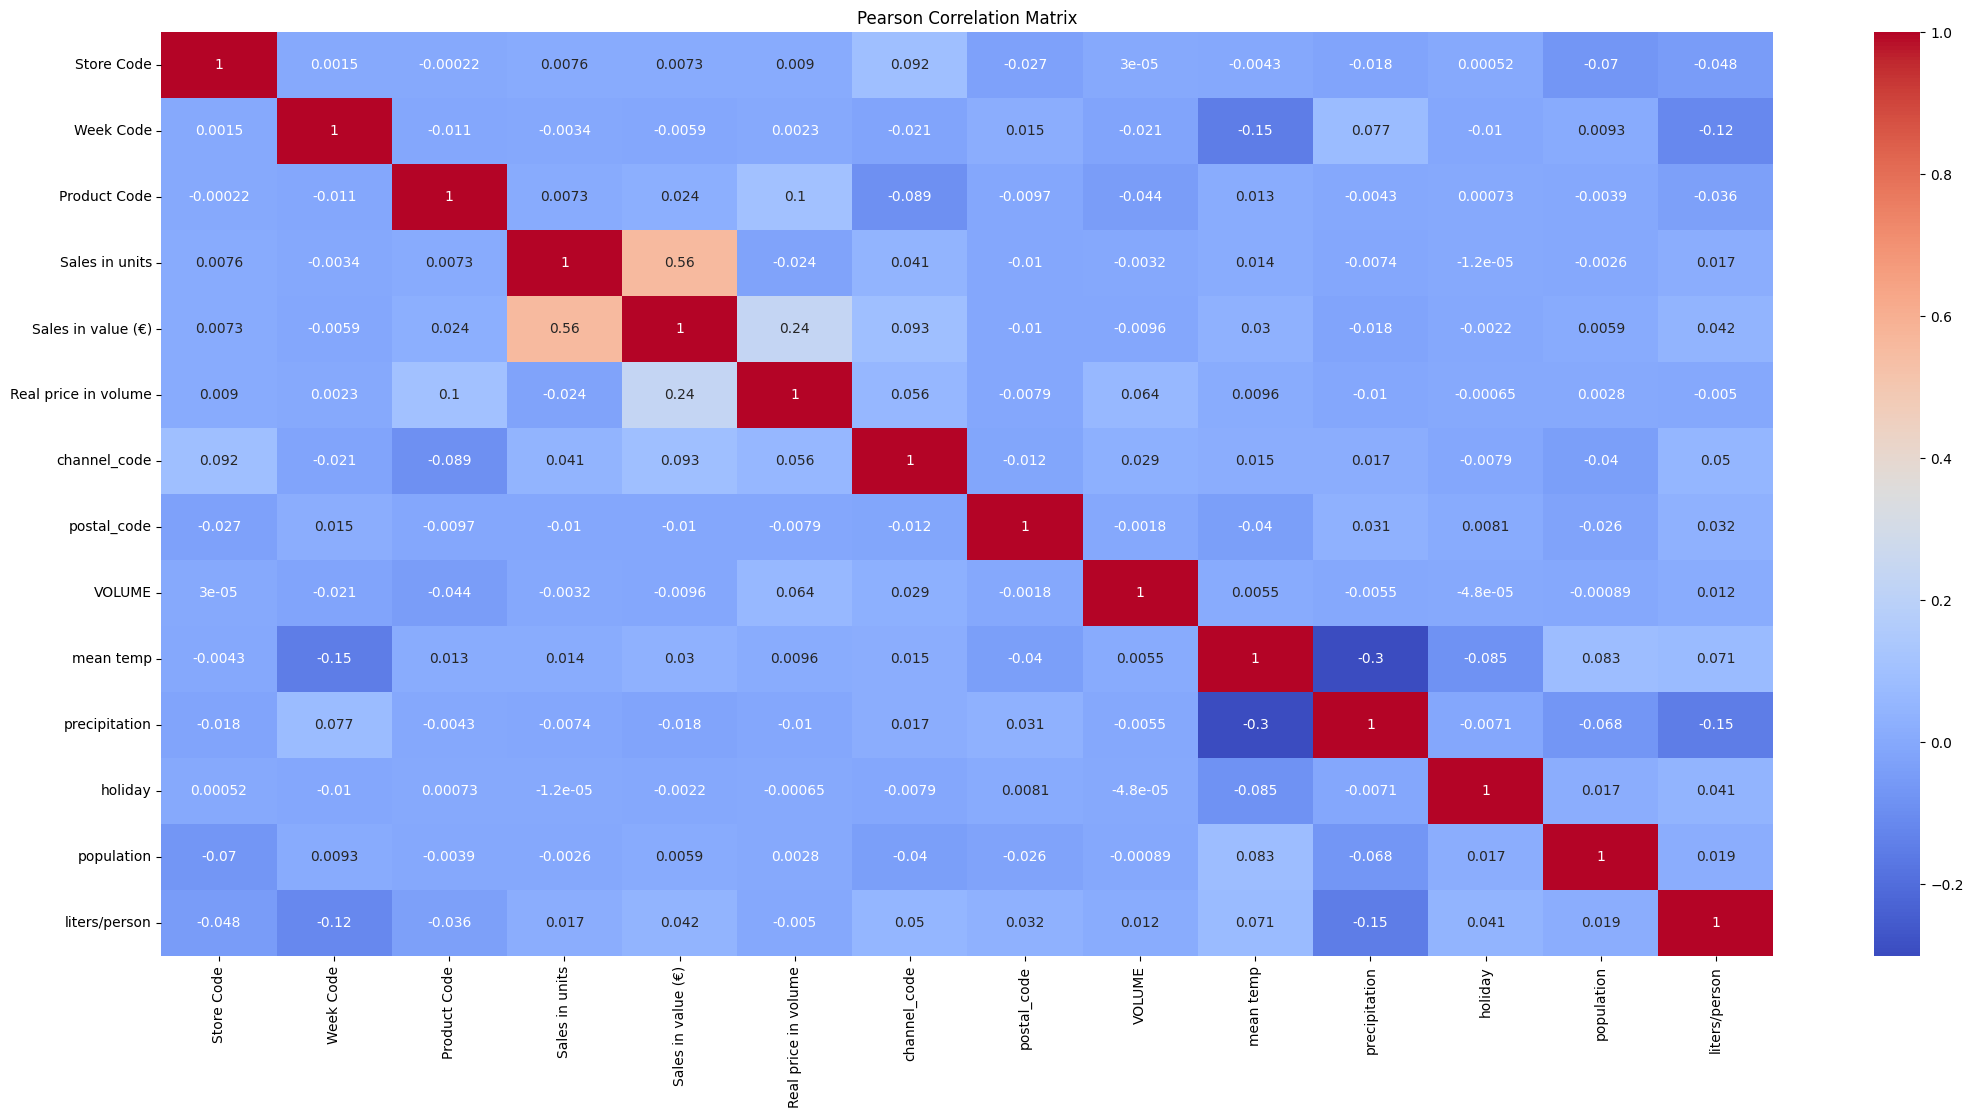

In [77]:
plt.figure(figsize=(26, 12))
sns.heatmap(circana.corr(), annot=True, cmap='coolwarm')
plt.title('Pearson Correlation Matrix')
plt.show()

After the drop there are no variables left with a high correlation. Now checking again the correlation with the target variable to double check.

In [78]:
circana.corr()[['Sales in value (€)']].sort_values('Sales in value (€)')

C:\Users\JuanHorrillo\AppData\Local\Temp\ipykernel_40152\3058420258.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  circana.corr()[['Sales in value (€)']].sort_values('Sales in value (€)')


Sales in value (€)
precipitation                  -0.017863
postal_code                    -0.010456
VOLUME                         -0.009553
Week Code                      -0.005895
holiday                        -0.002224
population                      0.005942
Store Code                      0.007324
Product Code                    0.024070
mean temp                       0.030037
liters/person                   0.042415
channel_code                    0.092930
Real price in volume            0.237312
Sales in units                  0.555218
Sales in value (€)              1.000000

## <span style="color: purple">**3. Data Preparation**</span> <a class="anchor" id="section_3"></a>

We will apply one hot encoding to variables that are categorical.

In [79]:
#OHE Season
circana = pd.get_dummies(circana, columns=['Season'], prefix = ['Season'])
#OHE Segment
circana = pd.get_dummies(circana, columns=['SEGMENT'], prefix = ['SEGMENT'])
#OHE Channels

#OHE Comunidad autónoma
#circana = pd.get_dummies(circana, columns=['Comunidad autónoma'], prefix = ['Comunidad autónoma'])
#OHE BRAND
#circana = pd.get_dummies(circana, columns=['BRAND'], prefix = ['BRAND'])
#OHE PACKAGING
circana = pd.get_dummies(circana, columns=['PACKAGING'], prefix = ['PACK'])
#OHE promocion
circana = pd.get_dummies(circana, columns=['promotion'], prefix = ['promo'])
#OHE promocion
circana = pd.get_dummies(circana, columns=['MANUFACTURER'], prefix = ['Manuf'])

Checking again the correlation with target variable.

In [80]:
circana.corr()[['Sales in value (€)']].sort_values('Sales in value (€)')

Sales in value (€)
promo_None                           -0.133372
PACK_CRISTAL BOTTLE                  -0.096053
Manuf_OTHER MANUFACTURERS            -0.072705
SEGMENT_IMPORT SPECIAL               -0.049611
SEGMENT_FLAVOURED                    -0.036124
SEGMENT_BLACK                        -0.034810
SEGMENT_ARTISANS                     -0.026643
SEGMENT_ZERO ALCOHOL                 -0.025202
SEGMENT_CELIACS                      -0.022147
SEGMENT_WITHOUT ALCOHOL              -0.019997
SEGMENT_EXTRA                        -0.019828
Season_Winter                        -0.017878
precipitation                        -0.017863
Manuf_MANUFACTURER 5                 -0.015328
Season_Autumn                        -0.010782
postal_code                          -0.010456
VOLUME                               -0.009553
Manuf_MANUFACTURER 1                 -0.007936
PACK_PET                             -0.006995
Week Code                            -0.005895
PACK_OTHER                           -0.002799
holiday                              -0.002224
promo_Promo regalo                   -0.000714
promo_Promo isla                      0.002544
population                            0.005942
SEGMENT_IMPORT PREMIUM                0.006806
Season_Spring                         0.007126
Store Code                            0.007324
promo_Promo extra cantidad            0.007954
Manuf_MANUFACTURER 4                  0.009746
Manuf_MANUFACTURER 2                  0.013033
Season_Summer                         0.022610
Product Code                          0.024070
mean temp                             0.030037
Manuf_MANUFACTURER 3                  0.035859
Manuf_MANUFACTURER 6                  0.035980
liters/person                         0.042415
promo_Promo descuento                 0.042761
promo_Promo multicompra               0.054177
promo_Promo folleto                   0.065351
promo_Promo expositor                 0.070652
channel_code                          0.092930
promo_Promo cabecera                  0.096139
PACK_CAN                              0.097451
SEGMENT_NATIONAL                      0.116435
Real price in volume                  0.237312
Sales in units                        0.555218
Sales in value (€)                    1.000000

In [81]:
circana.head()

Store Code  Week Code  Product Code  Sales in units  Sales in value (€)  \
0         243         42           236              30               19.50   
1         243        108           236              17               11.05   
2         243         68           236               9                4.95   
3         243         11           236              33               15.84   
4         243         49           236               3                1.95   

   Real price in volume  channel_code  postal_code  VOLUME  mean temp  \
0                  0.33             1        26003     330   8.800000   
1                  0.33             1        26003     330   6.671429   
2                  0.33             1        26003     330  15.500000   
3                  0.33             1        26003     330   8.114286   
4                  0.33             1        26003     330   2.600000   

   precipitation  holiday  population  liters/person  Season_Autumn  \
0       1.285714        0      241713       1.842685              1   
1       1.800000        0      241713       0.358632              0   
2       1.771429        1      241713       1.924468              0   
3       2.785714        1      241713       1.842685              0   
4       0.071429        1      241713       1.842685              0   

   Season_Spring  Season_Summer  Season_Winter  SEGMENT_ARTISANS  \
0              0              0              0                 0   
1              0              0              1                 0   
2              1              0              0                 0   
3              1              0              0                 0   
4              0              0              1                 0   

   SEGMENT_BLACK  SEGMENT_CELIACS  SEGMENT_EXTRA  SEGMENT_FLAVOURED  \
0              0                0              1                  0   
1              0                0              1                  0   
2              0                0              1                  0   
3              0                0              1                  0   
4              0                0              1                  0   

   SEGMENT_IMPORT PREMIUM  SEGMENT_IMPORT SPECIAL  SEGMENT_NATIONAL  \
0                       0                       0                 0   
1                       0                       0                 0   
2                       0                       0                 0   
3                       0                       0                 0   
4                       0                       0                 0   

   SEGMENT_WITHOUT ALCOHOL  SEGMENT_ZERO ALCOHOL  PACK_CAN  \
0                        0                     0         1   
1                        0                     0         1   
2                        0                     0         1   
3                        0                     0         1   
4                        0                     0         1   

   PACK_CRISTAL BOTTLE  PACK_OTHER  PACK_PET  promo_None  \
0                    0           0         0           1   
1                    0           0         0           1   
2                    0           0         0           1   
3                    0           0         0           0   
4                    0           0         0           1   

   promo_Promo cabecera  promo_Promo descuento  promo_Promo expositor  \
0                     0                      0                      0   
1                     0                      0                      0   
2                     0                      0                      0   
3                     0                      1                      0   
4                     0                      0                      0   

   promo_Promo extra cantidad  promo_Promo folleto  promo_Promo isla  \
0                           0                    0                 0   
1                           0                    0                 0   
2               

Drawing again the correlation matrix after the One Hot Encoding.

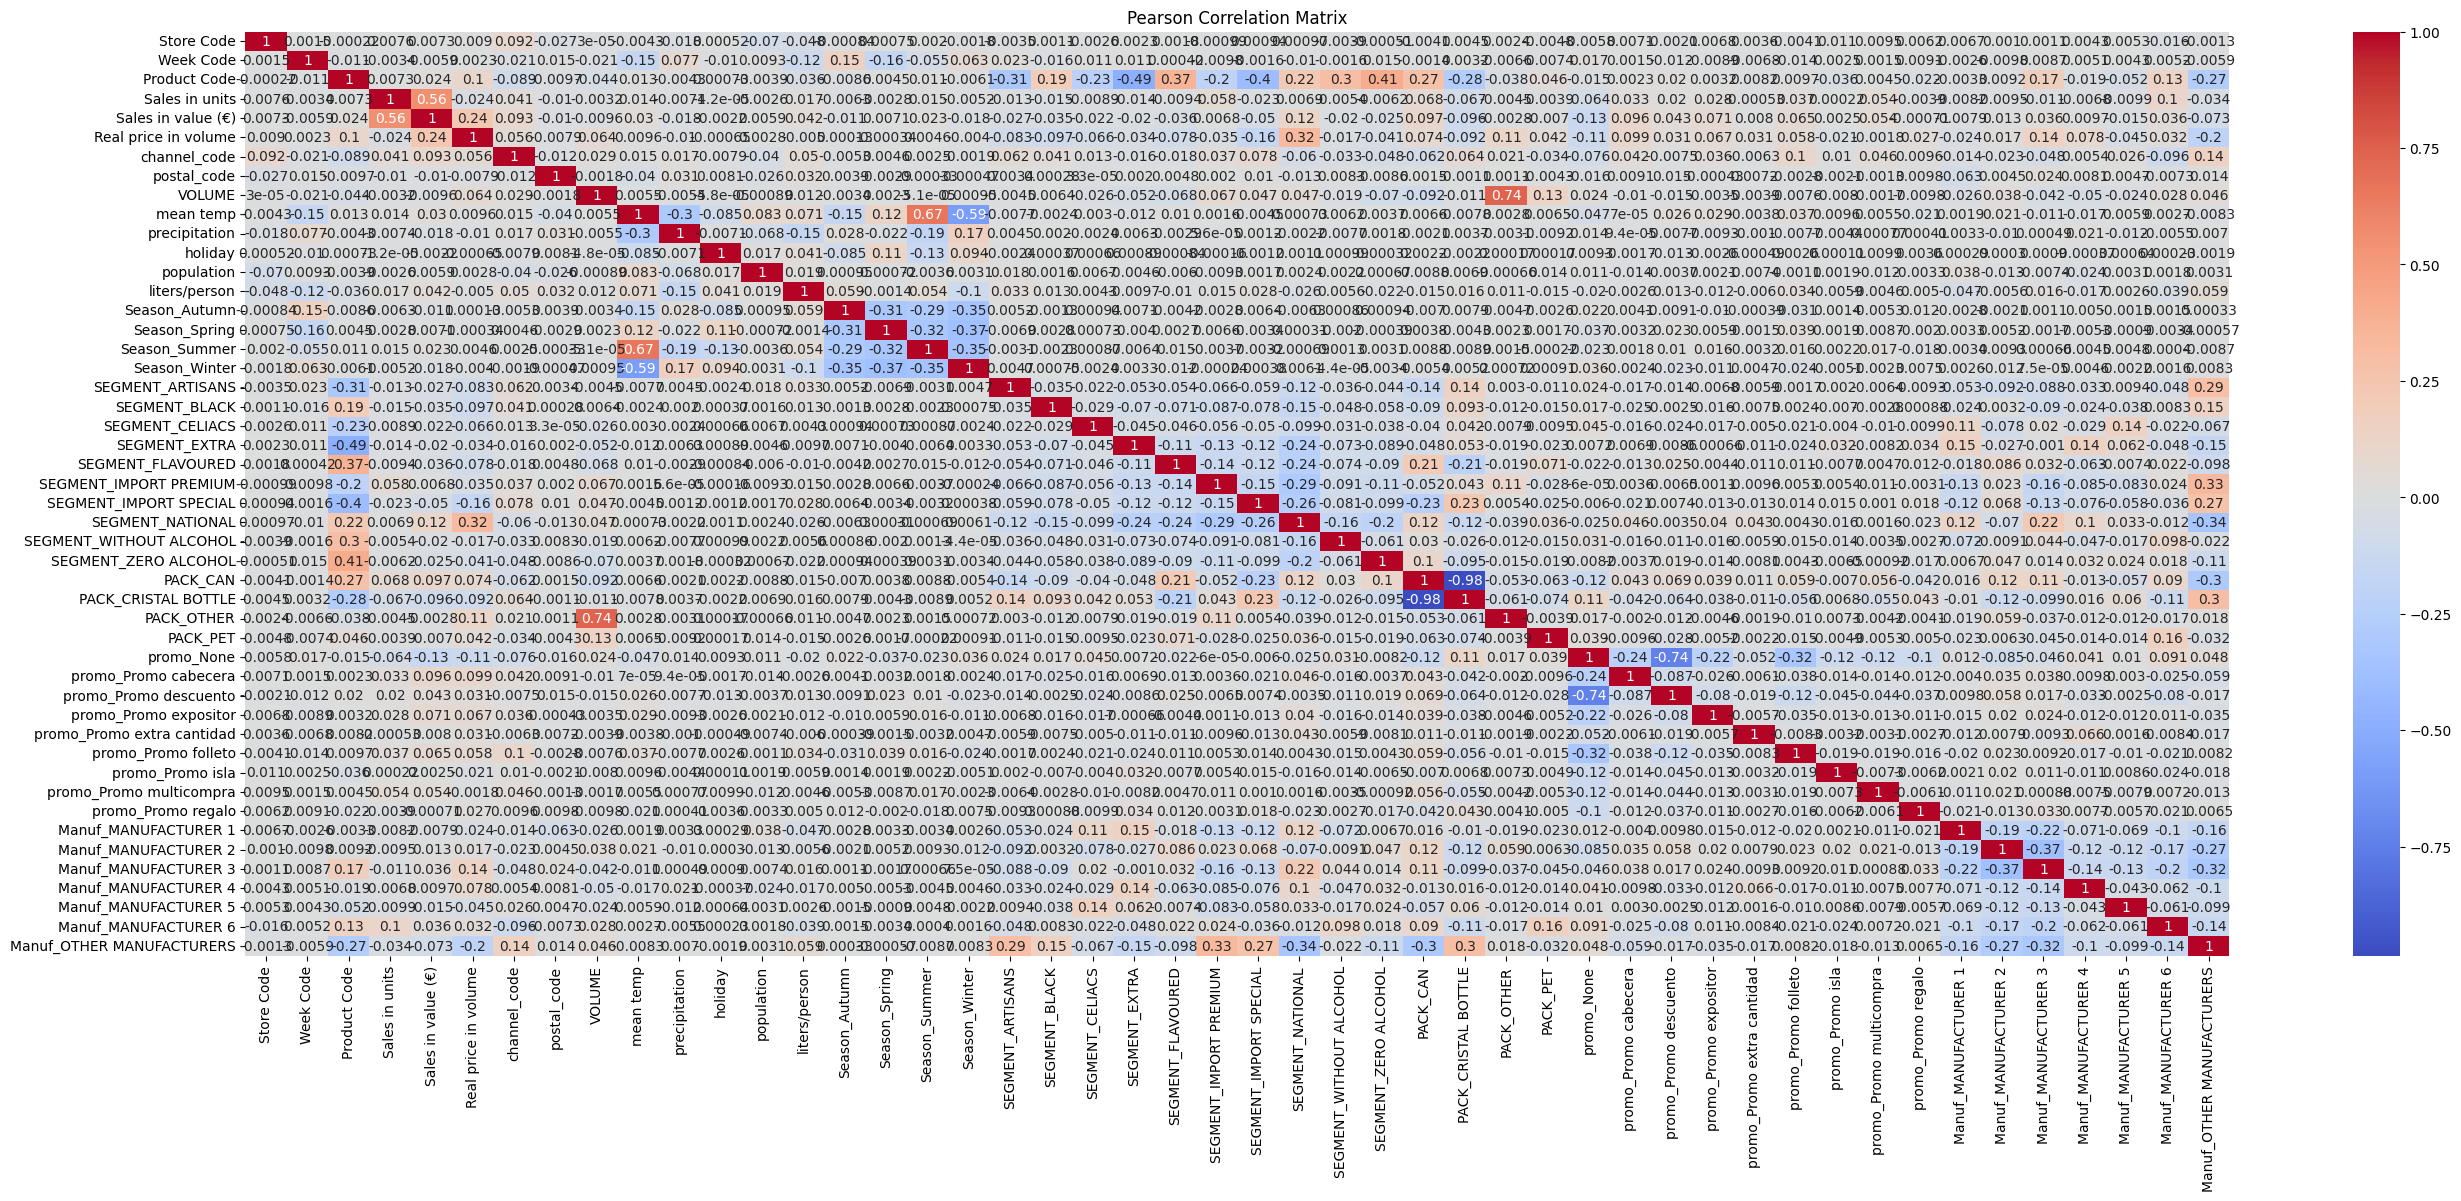

In [82]:
plt.figure(figsize=(32, 12))
sns.heatmap(circana.corr(), annot=True, cmap='coolwarm')
plt.title('Pearson Correlation Matrix')
plt.show()

Further drop of highly correlated variables.

In [83]:
#drop 'PACK_OTHER' 'PRO column
circana = circana.drop(['PACK_OTHER'], axis=1)

## <span style="color: purple">3.1 Outliers</span> <a class="anchor" id="section_3_1"></a>

We will now analyze if there are any outliers among the present data for our target variable.

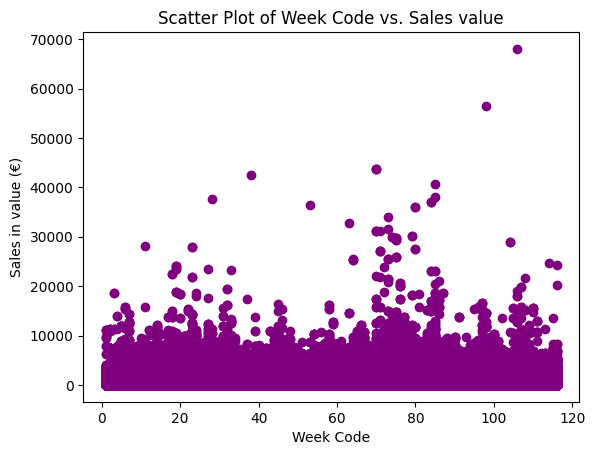

In [84]:
x = circana['Week Code']
y = circana['Sales in value (€)']

# Create scatter plot
plt.scatter(x, y, color = 'purple')
plt.xlabel('Week Code')
plt.ylabel('Sales in value (€)')
plt.title('Scatter Plot of Week Code vs. Sales value', )
plt.show()

There are a few points that can be considered outlieres, the model was run many times with and without outliers and it was noted that these did not have an impact on the outcome therefore it was decided to keep them.

## <span style="color: purple">**4. Prediction model**</span> <a class="anchor" id="section_4"></a>

## <span style="color: purple">4.1 Splitting the dataset</span> <a class="anchor" id="section_4_1"></a>

In [85]:
circana['Week Code'].min()

1

In [86]:
circana['Week Code'].max()

116

A train test split will be done with the first 80% of the values used for training and the last 20 weeks done for testing.

In [87]:
#  prepare the data for splitting: x and y
# x: features, y: target

train_data = circana[circana['Week Code'].between(1, 93)]  # Training data with week codes 1 to 93
test_data = circana[circana['Week Code'].between(94, 116)]  # Test data with week codes 94 to 116

# Split the data into features (X) and target variable (y) for training and testing
X_train = train_data.drop(columns=['Sales in value (€)'])
y_train = train_data['Sales in value (€)']
X_test = test_data.drop(columns=['Sales in value (€)'])
y_test = test_data['Sales in value (€)']

Checking the split

In [88]:
X_train.head()

Store Code  Week Code  Product Code  Sales in units  Real price in volume  \
0         243         42           236              30                  0.33   
2         243         68           236               9                  0.33   
3         243         11           236              33                  0.33   
4         243         49           236               3                  0.33   
5         243         22           236              43                  0.33   

   channel_code  postal_code  VOLUME  mean temp  precipitation  holiday  \
0             1        26003     330   8.800000       1.285714        0   
2             1        26003     330  15.500000       1.771429        1   
3             1        26003     330   8.114286       2.785714        1   
4             1        26003     330   2.600000       0.071429        1   
5             1        26003     330  20.800000       0.185714        0   

   population  liters/person  Season_Autumn  Season_Spring  Season_Summer  \
0      241713       1.842685              1              0              0   
2      241713       1.924468              0              1              0   
3      241713       1.842685              0              1              0   
4      241713       1.842685              0              0              0   
5      241713       1.842685              0              1              0   

   Season_Winter  SEGMENT_ARTISANS  SEGMENT_BLACK  SEGMENT_CELIACS  \
0              0                 0              0                0   
2              0                 0              0                0   
3              0                 0              0                0   
4              1                 0              0                0   
5              0                 0              0                0   

   SEGMENT_EXTRA  SEGMENT_FLAVOURED  SEGMENT_IMPORT PREMIUM  \
0              1                  0                       0   
2              1                  0                       0   
3              1                  0                       0   
4              1                  0                       0   
5              1                  0                       0   

   SEGMENT_IMPORT SPECIAL  SEGMENT_NATIONAL  SEGMENT_WITHOUT ALCOHOL  \
0                       0                 0                        0   
2                       0                 0                        0   
3                       0                 0                        0   
4                       0                 0                        0   
5                       0                 0                        0   

   SEGMENT_ZERO ALCOHOL  PACK_CAN  PACK_CRISTAL BOTTLE  PACK_PET  promo_None  \
0                     0         1                    0         0           1   
2                     0         1                    0         0           1   
3                     0         1                    0         0           0   
4                     0         1                    0         0           1   
5                     0         1                    0         0           0   

   promo_Promo cabecera  promo_Promo descuento  promo_Promo expositor  \
0                     0                      0                      0   
2                     0                      0                      0   
3                     0                      1                      0   
4                     0                      0                      0   
5                     0                      1                      0   

   promo_Promo extra cantidad  promo_Promo folleto  promo_Promo isla  \
0                           0                    0                 0   
2                           0                    0                 0   
3                           0                    0                 0   
4                           0                    0                 0   
5                           0                    0                 0   

   promo_Promo multico

Storing the names feature names for further uses.

In [89]:
feature_names = X_train.columns.tolist()

## <span style="color: purple">4.2. Linear Regression</span> <a class="anchor" id="section_4_2"></a>

The first model to be attempted will be a simple linear regression.

In [90]:
# Create the Linear Regression model
linear_model = LinearRegression()

# Fit the model to the training data
linear_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = linear_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_lr)
print("Mean Squared Error:", mse)


Mean Squared Error: 40280.32808894786


In [91]:
# Assuming 'y_true' are the actual target values and 'y_pred' are the predicted values
r_squared = r2_score(y_test, y_pred_lr)
print("R-squared Linear Regression:", r_squared)

R-squared Linear Regression: 0.4170085593493602


R-squared value is very low, this is almost expected as the data does not have a linear behaviour.

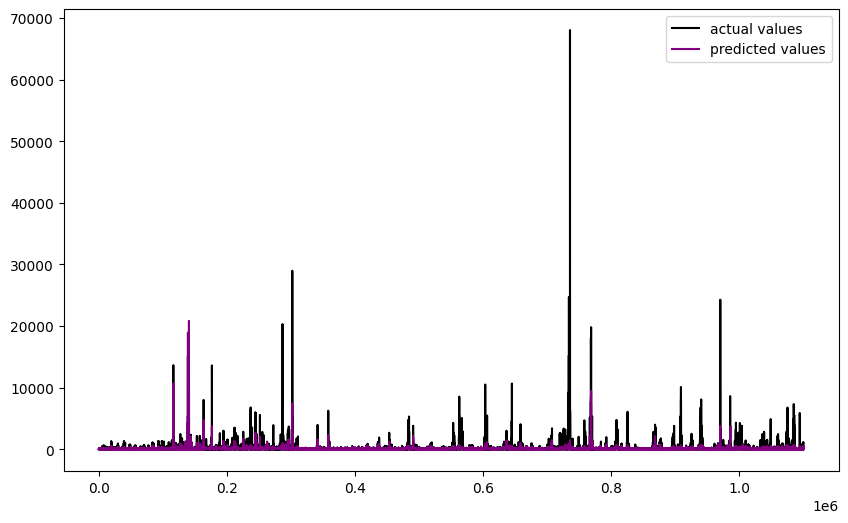

In [92]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(y_test.values, label="actual values", c="black")
ax.plot(y_pred_lr, label="predicted values", c="purple")
ax.legend()

Checking the coefficients of the regression to see if it is possible to obtain any interpretation.

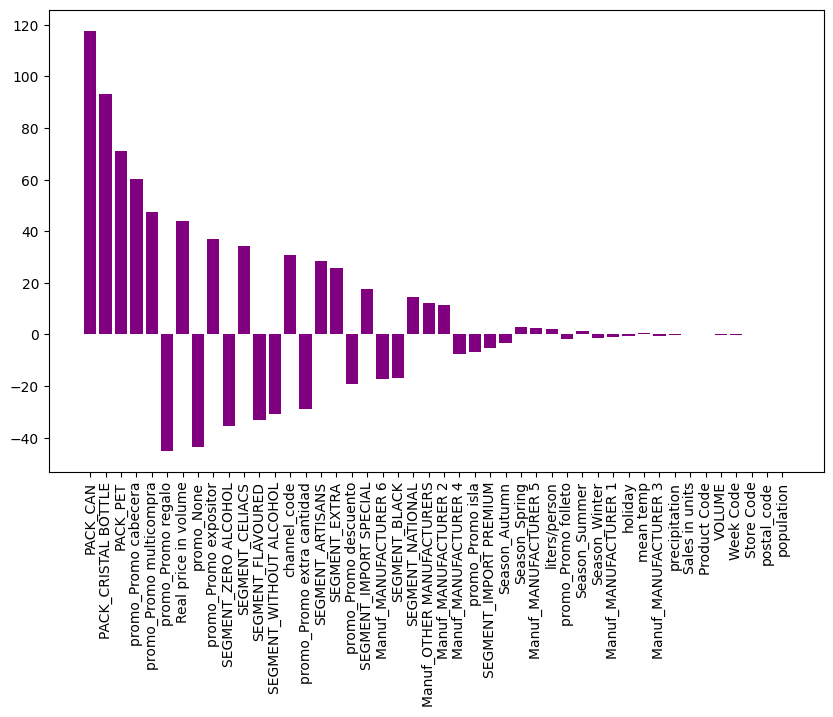

In [93]:

# Get coefficients
coefficients = linear_model.coef_

# Get the index of coefficients from greatest absolute value to least
sorted_index = np.argsort(np.abs(coefficients))[::-1]
x = range(len(coefficients))

# Create tick labels
labels = np.array(X_train.columns)[sorted_index]

# Create new figure
plt.figure(figsize=(10, 6))  # Adjust figure size here

# Create bar chart
plt.bar(x, coefficients[sorted_index], tick_label=labels, color='purple')

# Rotate tick labels to vertical
plt.xticks(rotation=90)

# Show plot
plt.show()


## <span style="color: purple">4.3. Random Forest</span> <a class="anchor" id="section_4_3"></a>

A Random Forest will now be applied in order to obtain a better model.

In [94]:
rf = RandomForestRegressor(n_estimators=10, random_state=42)

In [95]:
# train the model
rf_model = rf.fit(X_train, y_train)

# create prediction
y_hat_RF = rf.predict(X_test)

In [96]:
r_squared_rf = r2_score(y_test, y_hat_RF)
print("R-squared Random Forest:", r_squared_rf)

R-squared Random Forest: 0.9493248741832042


R squared error for random forest is low so it will not be considered. 

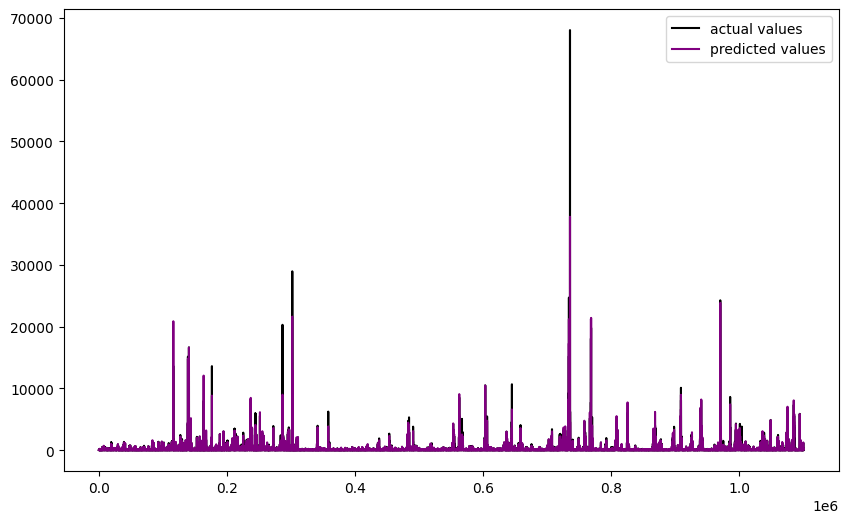

In [97]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(y_test.values, label="actual values", c="black")
ax.plot(y_hat_RF, label="predicted values", c="purple")
ax.legend()

Model follows better the data but still not enough to draw meaningful conclusions. 

Now, we will sort the importances of the model

In [98]:
importance_dict = dict(zip(X_train.columns, rf.feature_importances_))
sorted_importance_rf = dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

for feature, importance in sorted_importance_rf.items():
    print(f"{feature}: {importance}")

Sales in units: 0.5501187153376976
Real price in volume: 0.3953077196096901
Manuf_MANUFACTURER 6: 0.015872734434023306
Product Code: 0.006156211651284048
VOLUME: 0.005906287770533093
channel_code: 0.0035002884042214764
liters/person: 0.003317811016044311
population: 0.003298740055930572
postal_code: 0.002299176283654332
PACK_CAN: 0.002129617237355803
mean temp: 0.0019024851723333264
promo_None: 0.001781808351488847
precipitation: 0.0014715769331009793
PACK_CRISTAL BOTTLE: 0.0013358008135584726
Week Code: 0.001321040604841927
Store Code: 0.0013041159992941466
Manuf_MANUFACTURER 1: 0.0004612382638296761
Manuf_MANUFACTURER 2: 0.0003645356535944512
SEGMENT_EXTRA: 0.00030400055559794717
Manuf_MANUFACTURER 3: 0.00024679446101913535
Manuf_OTHER MANUFACTURERS: 0.0001926691576001763
SEGMENT_IMPORT SPECIAL: 0.00014855382138213166
Season_Spring: 0.0001445484029553916
SEGMENT_IMPORT PREMIUM: 0.0001416833989791489
holiday: 0.00013455578445688748
Manuf_MANUFACTURER 5: 0.00013128934173270738
Season_S

Applying a lime library to check how the model variables are affecting the prediction.

In [99]:
import lime
import lime.lime_tabular

# create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                   mode='regression',
                                                   feature_names=X_train.columns.values,
                                                   categorical_names=feature_names,
                                                   discretize_continuous=True)

# We need to provide the categorical_features (indices to the categorical columns)
# and categorical_names (a list of names of the categories for each categorical column) if
# our data contains categorical columns.

# explain the model's predictions using the training set
exp = explainer.explain_instance(X_test.values[0], rf.predict, num_features=X_test.shape[1])

# num_features is the maximum number of features present in an explanation

# list the features and their importance to the model's prediction
print(exp.as_list())


[('Real price in volume <= 0.33', -594.2343036778223), ('10.00 < Sales in units <= 31.00', -591.687797940561), ('PACK_PET <= 0.00', 348.57039356641076), ('promo_Promo expositor <= 0.00', -319.13811229033456), ('promo_Promo cabecera <= 0.00', 246.34051286367108), ('promo_Promo multicompra <= 0.00', 210.21833665865844), ('SEGMENT_BLACK <= 0.00', 200.87079660866974), ('SEGMENT_ARTISANS <= 0.00', 179.45004826830979), ('Manuf_MANUFACTURER 5 <= 0.00', 173.76766183165896), ('Manuf_MANUFACTURER 6 <= 0.00', 172.52871996211226), ('promo_Promo extra cantidad <= 0.00', 166.27826519103044), ('SEGMENT_WITHOUT ALCOHOL <= 0.00', -159.1069211720271), ('PACK_CRISTAL BOTTLE <= 0.00', -149.73691230683397), ('Manuf_MANUFACTURER 2 > 0.00', -134.0810536613001), ('promo_Promo folleto <= 0.00', 126.47128565022022), ('promo_Promo isla <= 0.00', 126.31412895828412), ('Manuf_MANUFACTURER 1 <= 0.00', 123.27625007675695), ('SEGMENT_ZERO ALCOHOL <= 0.00', 110.18450341123479), ('SEGMENT_IMPORT PREMIUM <= 0.00', 96.72

c:\Users\JuanHorrillo\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


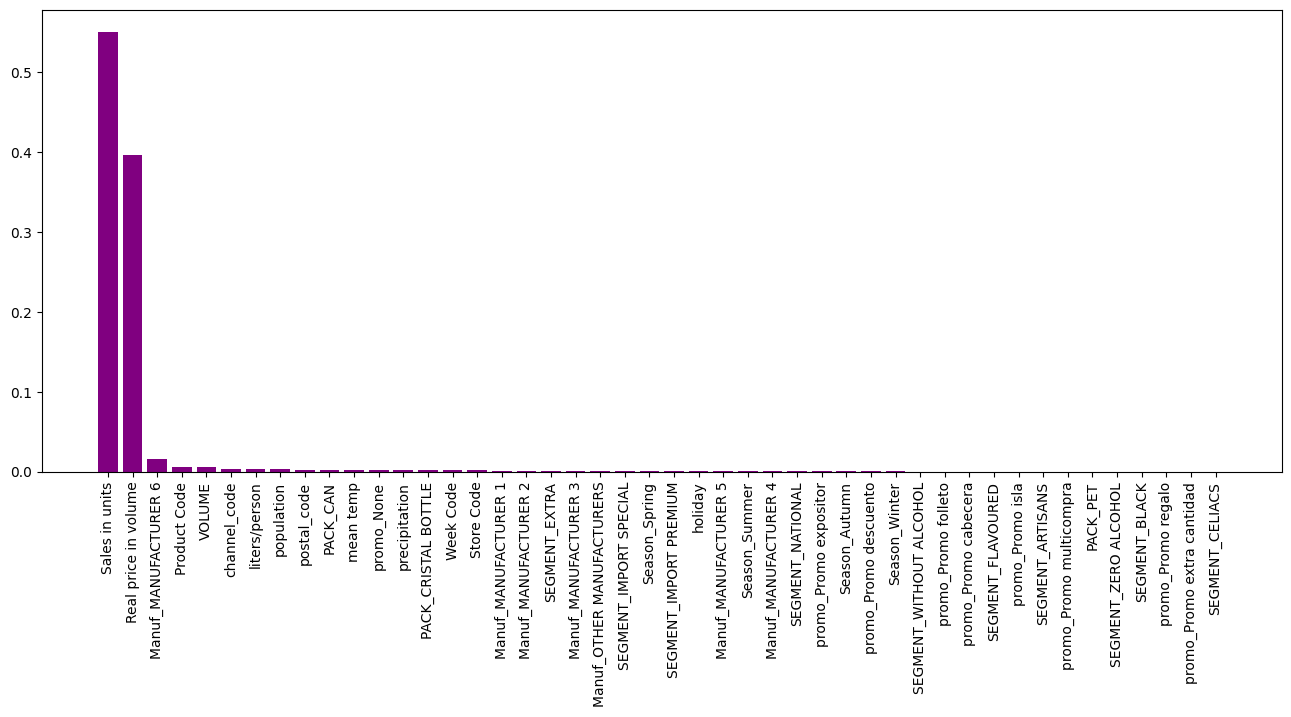

In [100]:
#Get feature importances
importances = rf.feature_importances_

#Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

#Create tick labels
labels = np.array(X_train.columns)[sorted_index]

plt.figure(figsize=(16, 6))

#Create bar chart
plt.bar(x, importances[sorted_index], tick_label=labels, color='purple')

#Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

The model performs very well but it is attributing most of the variables to sales in units so not enough insight for the purpose of this exercise.

## <span style="color: purple">4.4. XGBoost</span> <a class="anchor" id="section_4_4"></a>

Now, we will apply an XGBoost algorithm to see if we can obtain a better model.

In [101]:
# Create the XGBoost regression model
xgb_model = xgb.XGBRegressor()

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_hat_xgb = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_hat_xgb)
print("Mean Squared Error:", mse)

Mean Squared Error: 13625.866366943044


In [102]:
# Assuming 'y_true' are the actual target values and 'y_pred' are the predicted values
r_squared = r2_score(y_test, y_hat_xgb)
print("R-squared:", r_squared)

R-squared: 0.8027880148881698


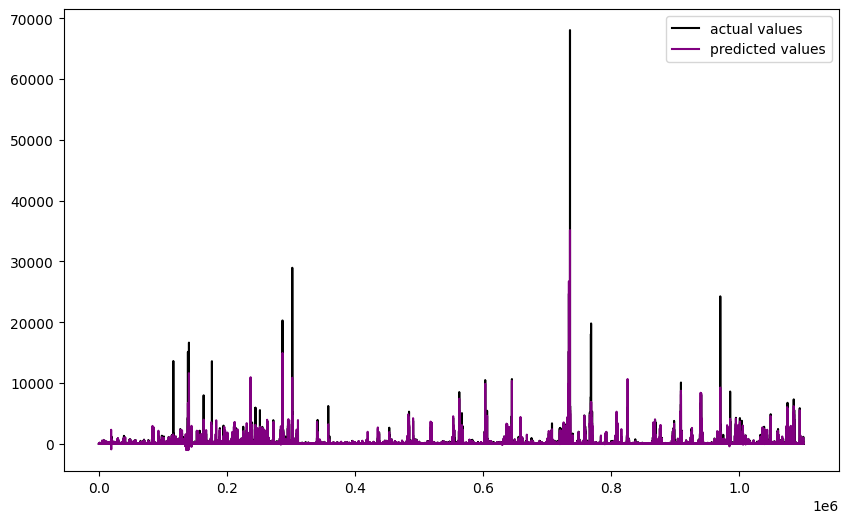

In [103]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(y_test.values, label="actual values", c="black")
ax.plot(y_hat_xgb, label="predicted values", c="purple")
ax.legend()

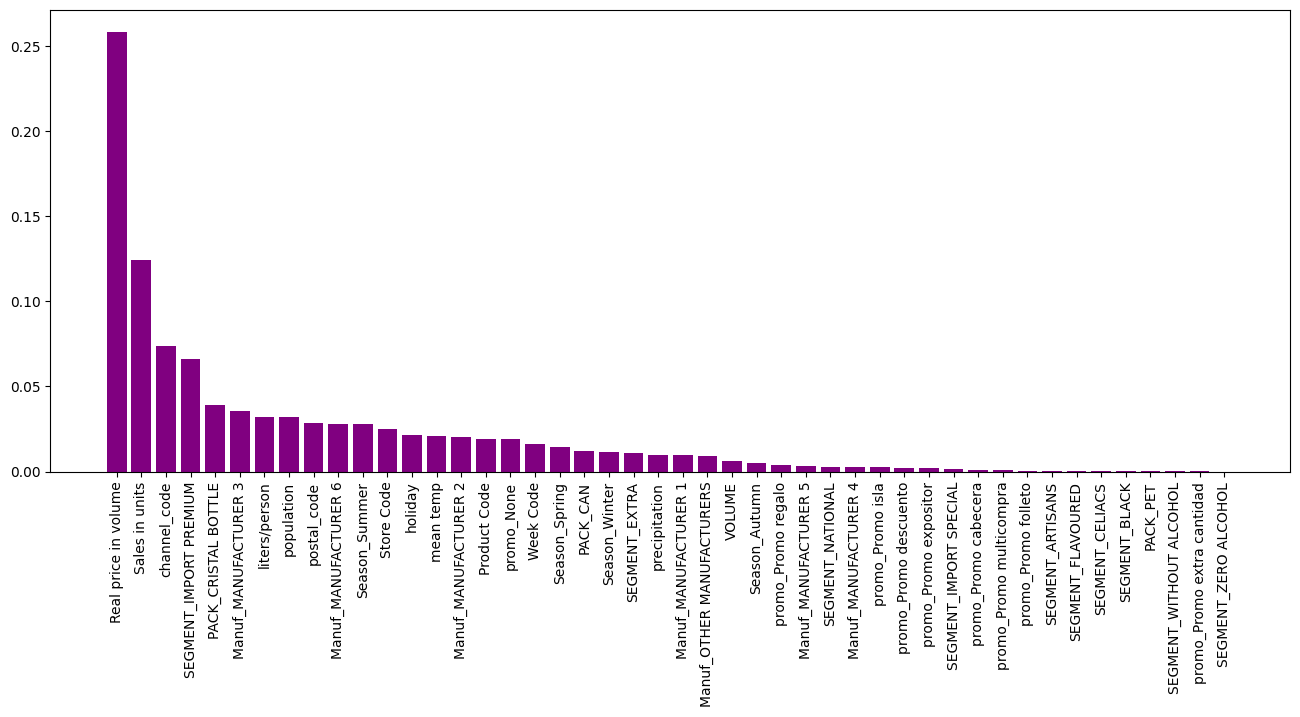

In [104]:
# Get feature importances
importances = xgb_model.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels
labels = np.array(X_train.columns)[sorted_index]

# Create new figure
plt.figure(figsize=(16, 6))  # Adjust figure size here

# Create bar chart
plt.bar(x, importances[sorted_index], tick_label=labels, color = 'purple')

# Rotate tick labels to vertical
plt.xticks(rotation=90)

# Show plot
plt.show()

The model has an acceptable R-squared value and it is giving weight to more of the features so it will be the one chosen to explain the main drivers.

In [105]:
importance_dict = dict(zip(X_train.columns, xgb_model.feature_importances_))
sorted_importance_xgb = dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

for feature, importance in sorted_importance_xgb.items():
    print(f"{feature}: {importance}")

Real price in volume: 0.258256733417511
Sales in units: 0.12400863319635391
channel_code: 0.0735340341925621
SEGMENT_IMPORT PREMIUM: 0.0663289874792099
PACK_CRISTAL BOTTLE: 0.038792967796325684
Manuf_MANUFACTURER 3: 0.03569299727678299
liters/person: 0.03198346868157387
population: 0.03191967308521271
postal_code: 0.028350766748189926
Manuf_MANUFACTURER 6: 0.027912883087992668
Season_Summer: 0.02767176367342472
Store Code: 0.025013037025928497
holiday: 0.02125183306634426
mean temp: 0.021075109019875526
Manuf_MANUFACTURER 2: 0.01999593898653984
Product Code: 0.019130690023303032
promo_None: 0.01905224099755287
Week Code: 0.016031833365559578
Season_Spring: 0.014582931064069271
PACK_CAN: 0.012178814969956875
Season_Winter: 0.011288782581686974
SEGMENT_EXTRA: 0.011052667163312435
precipitation: 0.009966718964278698
Manuf_MANUFACTURER 1: 0.009627239778637886
Manuf_OTHER MANUFACTURERS: 0.008922595530748367
VOLUME: 0.0061537157744169235
Season_Autumn: 0.005097034387290478
promo_Promo regalo

## <span style="color: purple">4.5. Creating functions to run the XGboost steps for the following regressions </span> <a class="anchor" id="section_4_5"></a>

A series of functions will be created to run XGBoost a number of times. 

In [106]:
#split the data
def split_train(circana_reduced):
    train_data = circana_reduced[circana_reduced['Week Code'].between(1, 93)]  # Training data with week codes 1 to 93
    test_data = circana_reduced[circana_reduced['Week Code'].between(94, 116)]  # Test data with week codes 94 to 116

    # Split the data into features (X) and target variable (y) for training and testing
    X_train_reduced = train_data.drop(columns=['Sales in value (€)'])
    y_train_reduced = train_data['Sales in value (€)']
    X_test_reduced = test_data.drop(columns=['Sales in value (€)'])
    y_test_reduced = test_data['Sales in value (€)']

    return X_train_reduced, y_train_reduced, X_test_reduced, y_test_reduced

def run_xgb_model(X_train, y_train, X_test, y_test):
    xgb_model = xgb.XGBRegressor()
    # Fit the model to the training data
    xgb_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = xgb_model.predict(X_test)

    # Evaluate the model using mean squared error
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)

    r_squared = r2_score(y_test, y_pred)
    print("R-squared:", r_squared)

    return y_pred, xgb_model

#plotting functions

def plot_predictions(Y_test, y_pred_reduced):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(Y_test.values, label="actual values", c="black")
    ax.plot(y_pred_reduced, label="predicted values", c="purple")
    ax.legend()
    plt.show()

    #importances = xgb_model.feature_importances_
    #plot_feature_importances(importances, X_train.columns)


def run_feature_importances(importances, feature_names):
    sorted_index = np.argsort(importances)[::-1]
    x = range(len(importances))
    labels = np.array(feature_names)[sorted_index]

    plt.figure(figsize=(16, 6))
    plt.bar(x, importances[sorted_index], tick_label=labels, color = 'purple')
    plt.xticks(rotation=90)
    plt.show()

# listing feature importances

    importance_dict = dict(zip(feature_names, importances))
    sorted_importance = dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

    for feature, importance in sorted_importance.items():
        print(f"{feature}: {importance}")
    return sorted_importance

def drop_features(importances, feature_names, threshold):
    importance_dict = dict(zip(feature_names, importances))
    sorted_importance = dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))
    
    features_to_drop = [feature for feature, importance in sorted_importance.items() if importance < threshold]
    X_dropped = pd.DataFrame.from_dict(sorted_importance, orient='index', columns=['Importance']).drop(features_to_drop, axis=0)
    
    
    print("Remaining features:")
    for feature in X_dropped.columns:
        print(feature)
    return X_dropped


def explain_predictions(X_train, X_test, y_train, model, num_features):
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                       mode='regression',
                                                       feature_names=X_train.columns.values,
                                                       categorical_names=None,
                                                       discretize_continuous=True)

    exp = explainer.explain_instance(X_test.values[0], model.predict, num_features=num_features)

    return exp.as_list()





## <span style="color: purple">**5. Improving the XGBoost Model**</span> <a class="anchor" id="section_5"></a>

We will re run XGB with less features as it was identified on the previous run that a lot of them did not contribute much to the model.

In [107]:
# Create a list of features to drop
features_to_drop = [feature for feature, importance in sorted_importance_xgb.items() if importance < 0.016]

# Drop the features from X_train DataFrame
X_train_light = X_train.drop(features_to_drop, axis=1)
X_test_light = X_test.drop(features_to_drop, axis=1)


# Print the remaining features
print("Remaining features:")
for feature in X_train_light.columns:
    print(feature)

Remaining features:
Store Code
Week Code
Product Code
Sales in units
Real price in volume
channel_code
postal_code
mean temp
holiday
population
liters/person
Season_Summer
SEGMENT_IMPORT PREMIUM
PACK_CRISTAL BOTTLE
promo_None
Manuf_MANUFACTURER 2
Manuf_MANUFACTURER 3
Manuf_MANUFACTURER 6


In [108]:
X_train_light.head()

Store Code  Week Code  Product Code  Sales in units  Real price in volume  \
0         243         42           236              30                  0.33   
2         243         68           236               9                  0.33   
3         243         11           236              33                  0.33   
4         243         49           236               3                  0.33   
5         243         22           236              43                  0.33   

   channel_code  postal_code  mean temp  holiday  population  liters/person  \
0             1        26003   8.800000        0      241713       1.842685   
2             1        26003  15.500000        1      241713       1.924468   
3             1        26003   8.114286        1      241713       1.842685   
4             1        26003   2.600000        1      241713       1.842685   
5             1        26003  20.800000        0      241713       1.842685   

   Season_Summer  SEGMENT_IMPORT PREMIUM  PACK_CRISTAL BOTTLE  promo_None  \
0              0                       0                    0           1   
2              0                       0                    0           1   
3              0                       0                    0           0   
4              0                       0                    0           1   
5              0                       0                    0           0   

   Manuf_MANUFACTURER 2  Manuf_MANUFACTURER 3  Manuf_MANUFACTURER 6  
0                     1                     0                     0  
2                     1                     0                     0  
3                     1                     0                     0  
4                     1                     0                     0  
5                     1                     0                     0

XGBoost regression with less features

In [109]:
y_hat_xgb_light, xgb_model_light = run_xgb_model( X_train_light, y_train, X_test_light, y_test)

Mean Squared Error: 15329.002674349871
R-squared: 0.7781379204975047


There is a small drop on the R-Squared value but model is simpler now with less features. 

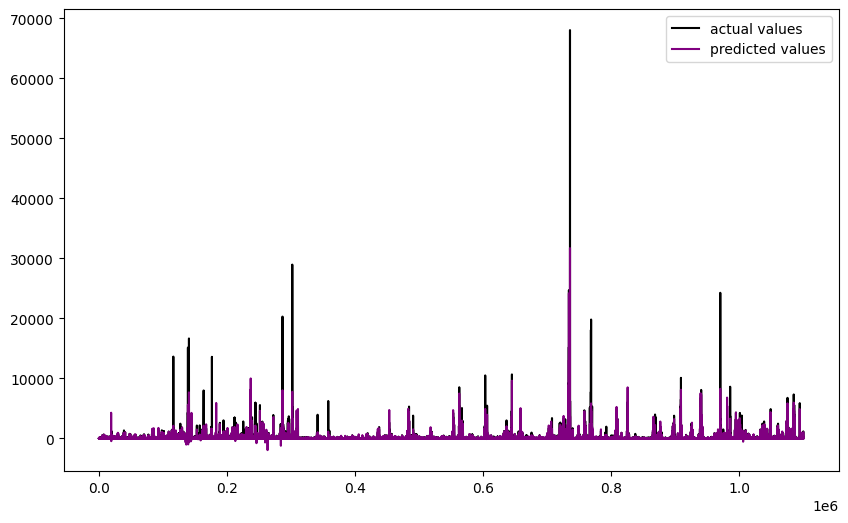

In [110]:
plot_predictions(y_test, y_hat_xgb_light)

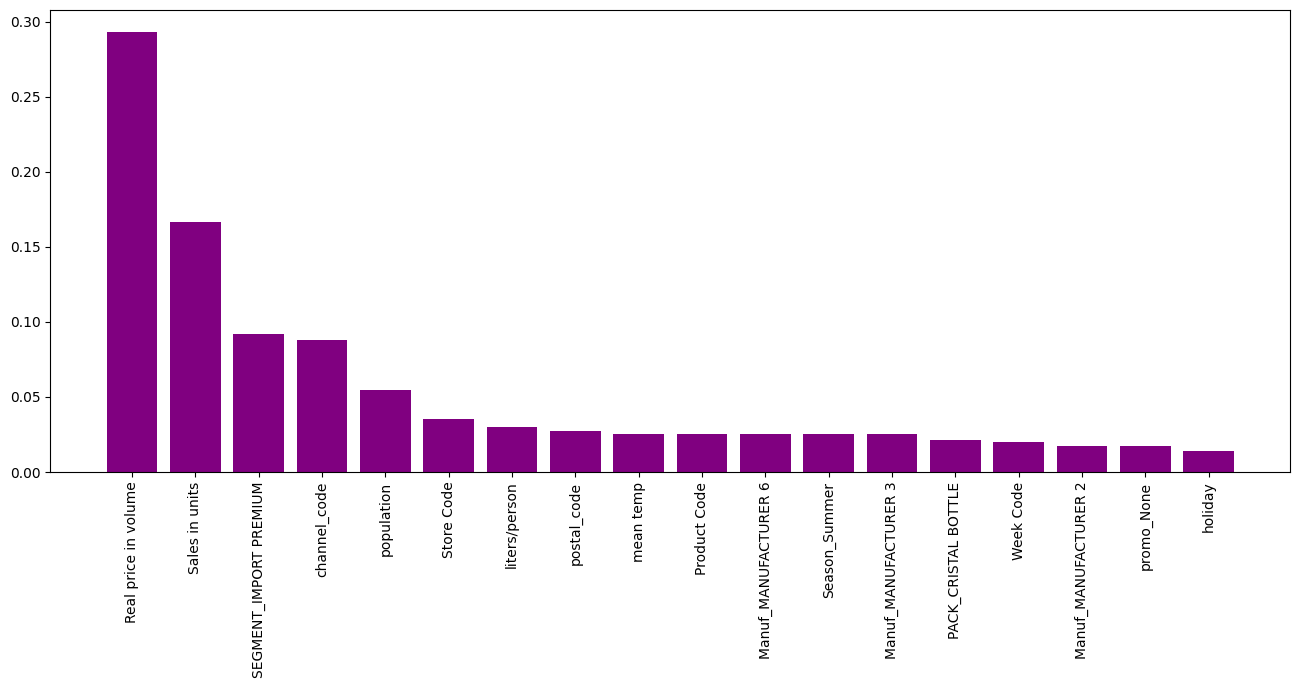

Real price in volume: 0.2931981086730957
Sales in units: 0.16638287901878357
SEGMENT_IMPORT PREMIUM: 0.09155295044183731
channel_code: 0.08760955184698105
population: 0.05442377179861069
Store Code: 0.035012658685445786
liters/person: 0.029692497104406357
postal_code: 0.02726365253329277
mean temp: 0.025484411045908928
Product Code: 0.025259023532271385
Manuf_MANUFACTURER 6: 0.025083987042307854
Season_Summer: 0.024948514997959137
Manuf_MANUFACTURER 3: 0.02490515448153019
PACK_CRISTAL BOTTLE: 0.02092692069709301
Week Code: 0.019856669008731842
Manuf_MANUFACTURER 2: 0.01730124093592167
promo_None: 0.016943126916885376
holiday: 0.014154958538711071


{'Real price in volume': 0.2931981,
 'Sales in units': 0.16638288,
 'SEGMENT_IMPORT PREMIUM': 0.09155295,
 'channel_code': 0.08760955,
 'population': 0.05442377,
 'Store Code': 0.03501266,
 'liters/person': 0.029692497,
 'postal_code': 0.027263653,
 'mean temp': 0.025484411,
 'Product Code': 0.025259024,
 'Manuf_MANUFACTURER 6': 0.025083987,
 'Season_Summer': 0.024948515,
 'Manuf_MANUFACTURER 3': 0.024905154,
 'PACK_CRISTAL BOTTLE': 0.02092692,
 'Week Code': 0.019856669,
 'Manuf_MANUFACTURER 2': 0.017301241,
 'promo_None': 0.016943127,
 'holiday': 0.014154959}

In [111]:
importances_light = xgb_model_light.feature_importances_
run_feature_importances(importances_light, X_train_light.columns)

In [112]:
# create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_light.values,
                                                   mode='regression',
                                                   feature_names=X_train_light.columns.values,
                                                   categorical_names=feature_names,
                                                   discretize_continuous=True)

# Note: You need to provide the categorical_features (indices to the categorical columns)
# and categorical_names (a list of names of the categories for each categorical column) if
# your data contains categorical columns. If you don't have categorical data, you can ignore
# these parameters.

# explain the model's predictions using the training set
exp = explainer.explain_instance(X_test_light.values[0], xgb_model_light.predict, num_features=X_test_light.shape[1])

# num_features is the maximum number of features present in an explanation

# list the features and their importance to the model's prediction
print(exp.as_list())

[('Real price in volume <= 0.33', -671.4779397486174), ('10.00 < Sales in units <= 31.00', -575.2482186674063), ('SEGMENT_IMPORT PREMIUM <= 0.00', -190.7393629032689), ('Manuf_MANUFACTURER 6 <= 0.00', 172.8637389549299), ('Product Code <= 524.00', 123.01569827534647), ('Season_Summer <= 0.00', 102.47304496472665), ('Manuf_MANUFACTURER 2 > 0.00', -98.1952575378147), ('158.00 < Store Code <= 282.00', 95.54827394231657), ('channel_code <= 1.00', -89.81326678734834), ('liters/person <= 3.34', 88.4067952290451), ('mean temp <= 11.80', -85.62013972960244), ('0.00 < promo_None <= 1.00', 73.99010243850908), ('Week Code > 71.00', -48.514141213424985), ('population <= 530436.00', -48.05309158584163), ('PACK_CRISTAL BOTTLE <= 0.00', -36.486132179173474), ('Manuf_MANUFACTURER 3 <= 0.00', 18.50823663611162), ('9007.00 < postal_code <= 28003.00', -16.137829251513207), ('holiday <= 0.00', 5.982946483041043)]


Plotting the features as a tree map.

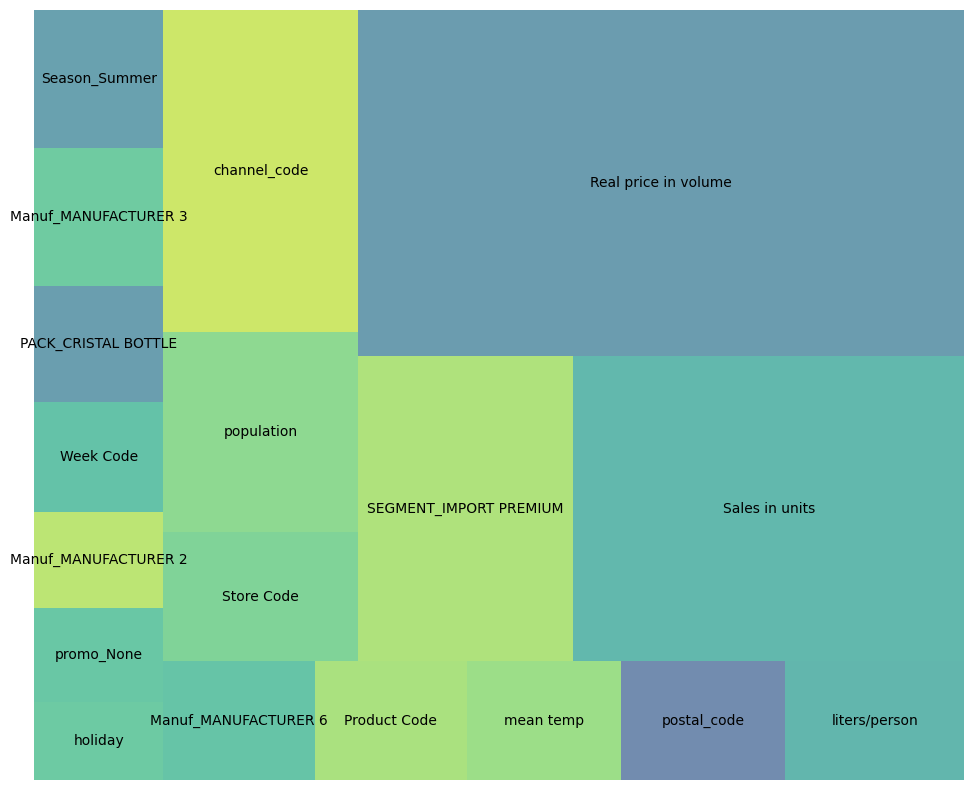

In [113]:
feature_importances = xgb_model_light.feature_importances_
# Normalize importances
norm_importances_light = 100.0 * (importances_light / importances_light.max())

# Get the index of importances from greatest importance to least
sorted_idx = np.argsort(feature_importances)[::-1]

# Take only the 20 most important features
pos = np.arange(sorted_idx.shape[0]) + .5
pos = pos[:20][::-1]

# Create tick labels
labels = np.array(X_train_light.columns)[sorted_idx][:20][::-1]

# Create figure
plt.figure(figsize=(12, 10))
squarify.plot(
                label=labels,
                sizes=norm_importances_light[sorted_idx][:20][::-1],
                alpha=.7)
plt.axis('off')
plt.show()


## <span style="color: purple">**6. Drivers for top 3 Manufacturers**</span> <a class="anchor" id="section_6"></a>

First, we have to start by identifying which are the top 3 manufacturers in terms of sales in value.

In [117]:
sales_sum_per_manufacturer = circana_copy.groupby("MANUFACTURER")["Sales in value (€)"].sum().sort_values(ascending=False)
print(sales_sum_per_manufacturer)

MANUFACTURER
MANUFACTURER 3         1.274349e+08
MANUFACTURER 2         8.985936e+07
MANUFACTURER 6         4.322113e+07
MANUFACTURER 1         3.012471e+07
MANUFACTURER 4         1.711185e+07
OTHER MANUFACTURERS    1.575757e+07
MANUFACTURER 5         8.365624e+06
Name: Sales in value (€), dtype: float64


## <span style="color: purple">6.1. Manufacturer 3: Drivers for sales</span> <a class="anchor" id="section_6_1"></a>

In [118]:
circana_m3 = circana[circana['Manuf_MANUFACTURER 3'] == 1]

In [119]:
circana_m3.head()

Store Code  Week Code  Product Code  Sales in units  \
70448         243         42           270               8   
70449         243         68           270               3   
70450         243         49           270               5   
70451         243        105           270               4   
70452         243         87           270               1   

       Sales in value (€)  Real price in volume  channel_code  postal_code  \
70448                7.92                  0.33             1        26003   
70449                2.97                  0.33             1        26003   
70450                4.95                  0.33             1        26003   
70451                3.92                  0.33             1        26003   
70452                0.98                  0.33             1        26003   

       VOLUME  mean temp  precipitation  holiday  population  liters/person  \
70448     330   8.800000       1.285714        0      241713       1.842685   
70449     330  15.500000       1.771429        1      241713       1.924468   
70450     330   2.600000       0.071429        1      241713       1.842685   
70451     330   6.400000       2.714286        1      241713       0.358632   
70452     330  16.285714       0.400000        0      241713       1.924468   

       Season_Autumn  Season_Spring  Season_Summer  Season_Winter  \
70448              1              0              0              0   
70449              0              1              0              0   
70450              0              0              0              1   
70451              0              0              0              1   
70452              0              0              1              0   

       SEGMENT_ARTISANS  SEGMENT_BLACK  SEGMENT_CELIACS  SEGMENT_EXTRA  \
70448                 0              0                0              1   
70449                 0              0                0              1   
70450                 0              0                0              1   
70451                 0              0                0              1   
70452                 0              0                0              1   

       SEGMENT_FLAVOURED  SEGMENT_IMPORT PREMIUM  SEGMENT_IMPORT SPECIAL  \
70448                  0                       0                       0   
70449                  0                       0                       0   
70450                  0                       0                       0   
70451                  0                       0                       0   
70452                  0                       0                       0   

       SEGMENT_NATIONAL  SEGMENT_WITHOUT ALCOHOL  SEGMENT_ZERO ALCOHOL  \
70448                 0                        0                     0   
70449                 0                        0                     0   
70450                 0                        0                     0   
70451                 0                        0                     0   
70452                 0                        0                     0   

       PACK_CAN  PACK_CRISTAL BOTTLE  PACK_PET  promo_None  \
70448         0                    1         0           0   
70449         0                    1         0           0   
70450         0                    1         0           0   
70451         0                    1         0           1   
70452         0                    1         0           1   

       promo_Promo cabecera  promo_Promo descuento  promo_Promo expositor  \
70448                     1                      0                      0   
70449                     1                      0                      0   
70450                     1                      0                      0   
70451                     0                      0                      0   
70452                     0                      0                      0   

       promo_Promo extra cantidad  promo_Promo folleto  promo_Promo isla  \
70448           

Running the regression for this manufacturer

In [120]:
#  prepare the data for splitting: x and y
# x: features, y: target

train_data = circana_m3[circana_m3['Week Code'].between(1, 93)]  # Training data with week codes 1 to 93
test_data = circana_m3[circana_m3['Week Code'].between(94, 116)]  # Test data with week codes 94 to 116

# Split the data into features (X) and target variable (y) for training and testing
X_train_m3 = train_data.drop(columns=['Sales in value (€)'])
y_train_m3 = train_data['Sales in value (€)']
X_test_m3 = test_data.drop(columns=['Sales in value (€)'])
y_test_m3 = test_data['Sales in value (€)']

In [121]:
X_test_m3 = X_test_m3.drop(['Manuf_MANUFACTURER 1', 'Manuf_MANUFACTURER 2','Manuf_MANUFACTURER 3','Manuf_MANUFACTURER 4','Manuf_MANUFACTURER 5','Manuf_MANUFACTURER 6','Manuf_OTHER MANUFACTURERS',], axis=1)
X_train_m3 = X_train_m3.drop(['Manuf_MANUFACTURER 1', 'Manuf_MANUFACTURER 2','Manuf_MANUFACTURER 3','Manuf_MANUFACTURER 4','Manuf_MANUFACTURER 5','Manuf_MANUFACTURER 6','Manuf_OTHER MANUFACTURERS',], axis=1)

In [122]:
y_hat_xgb_m3, xgb_model_m3 = run_xgb_model( X_train_m3, y_train_m3, X_test_m3, y_test_m3)

Mean Squared Error: 5738.493633612633
R-squared: 0.9558745544358168


Model has a very high R-square so it is good at predicting the drivers on this case. 

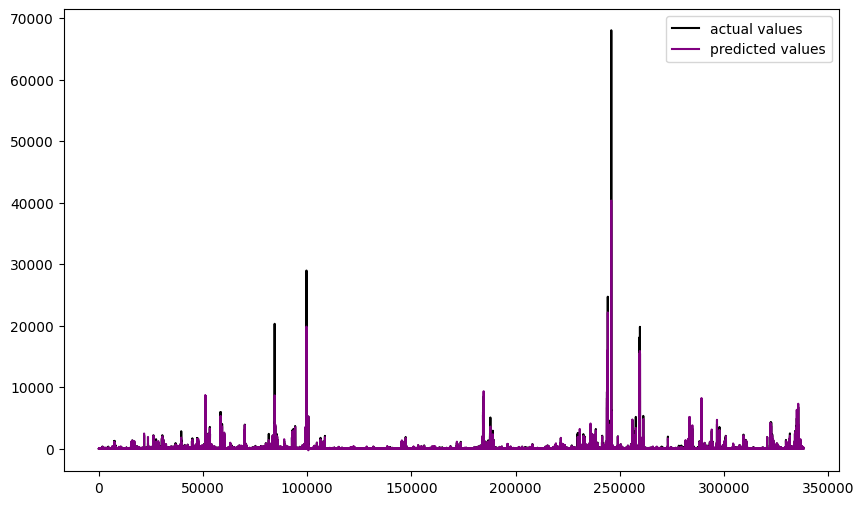

In [123]:
plot_predictions(y_test_m3, y_hat_xgb_m3)

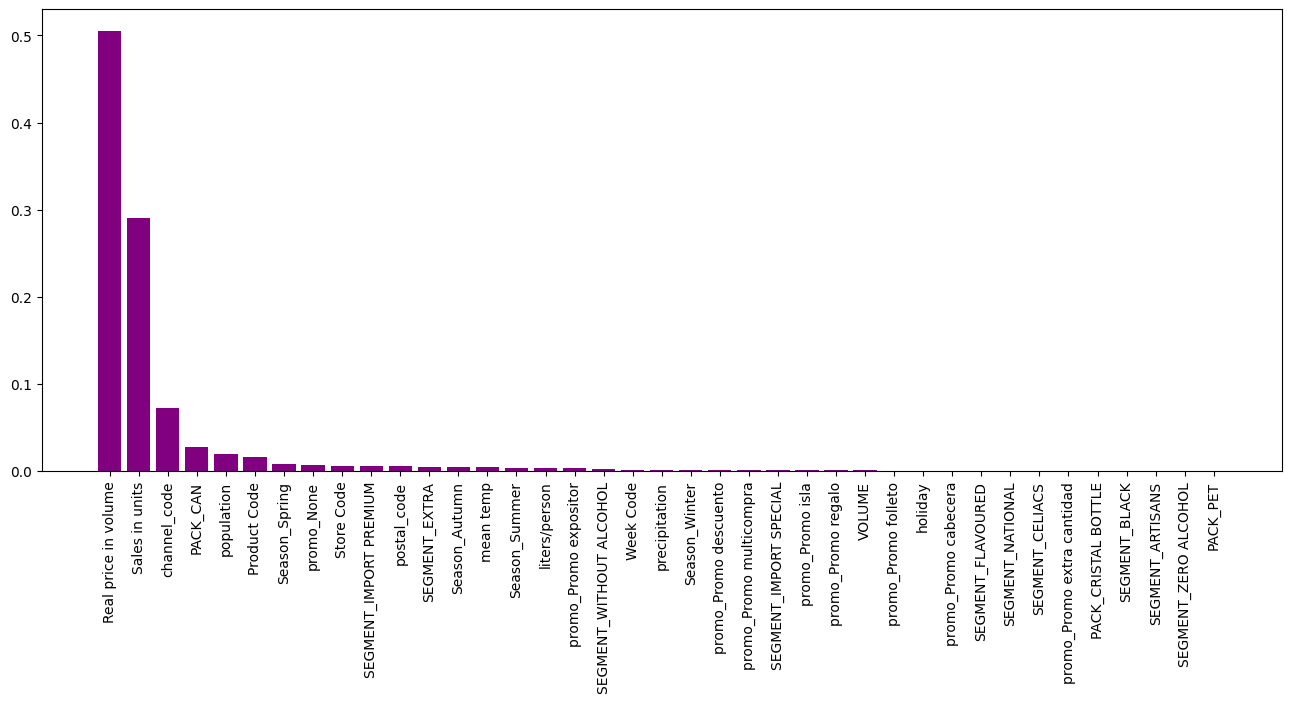

Real price in volume: 0.505132794380188
Sales in units: 0.29036200046539307
channel_code: 0.07277364283800125
PACK_CAN: 0.027646120637655258
population: 0.020058177411556244
Product Code: 0.016027875244617462
Season_Spring: 0.007653835229575634
promo_None: 0.007269433233886957
Store Code: 0.006081812083721161
SEGMENT_IMPORT PREMIUM: 0.00557016022503376
postal_code: 0.005387754645198584
SEGMENT_EXTRA: 0.005197774153202772
Season_Autumn: 0.00469220383092761
mean temp: 0.004096354823559523
Season_Summer: 0.00341893476434052
liters/person: 0.003298524534329772
promo_Promo expositor: 0.003255340736359358
SEGMENT_WITHOUT ALCOHOL: 0.0020713401027023792
Week Code: 0.001297668321058154
precipitation: 0.001151527394540608
Season_Winter: 0.0011178819695487618
promo_Promo descuento: 0.0010701147839426994
promo_Promo multicompra: 0.0007461252389475703
SEGMENT_IMPORT SPECIAL: 0.0007221668493002653
promo_Promo isla: 0.0006866197218187153
promo_Promo regalo: 0.0006744327256456017
VOLUME: 0.00061825406

{'Real price in volume': 0.5051328,
 'Sales in units': 0.290362,
 'channel_code': 0.07277364,
 'PACK_CAN': 0.02764612,
 'population': 0.020058177,
 'Product Code': 0.016027875,
 'Season_Spring': 0.007653835,
 'promo_None': 0.0072694332,
 'Store Code': 0.006081812,
 'SEGMENT_IMPORT PREMIUM': 0.00557016,
 'postal_code': 0.0053877546,
 'SEGMENT_EXTRA': 0.005197774,
 'Season_Autumn': 0.004692204,
 'mean temp': 0.004096355,
 'Season_Summer': 0.0034189348,
 'liters/person': 0.0032985245,
 'promo_Promo expositor': 0.0032553407,
 'SEGMENT_WITHOUT ALCOHOL': 0.00207134,
 'Week Code': 0.0012976683,
 'precipitation': 0.0011515274,
 'Season_Winter': 0.001117882,
 'promo_Promo descuento': 0.0010701148,
 'promo_Promo multicompra': 0.00074612524,
 'SEGMENT_IMPORT SPECIAL': 0.00072216685,
 'promo_Promo isla': 0.0006866197,
 'promo_Promo regalo': 0.0006744327,
 'VOLUME': 0.00061825407,
 'promo_Promo folleto': 0.0004043087,
 'holiday': 0.00036194356,
 'promo_Promo cabecera': 0.00031496122,
 'SEGMENT_FLAV

In [124]:
importances_m3 = xgb_model_m3.feature_importances_
run_feature_importances(importances_m3, X_train_m3.columns)


In [125]:
# create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_m3.values,
                                                   mode='regression',
                                                   feature_names=X_train_m3.columns.values,
                                                   categorical_names=feature_names,
                                                   discretize_continuous=True)

# Note: You need to provide the categorical_features (indices to the categorical columns)
# and categorical_names (a list of names of the categories for each categorical column) if
# your data contains categorical columns. If you don't have categorical data, you can ignore
# these parameters.

# explain the model's predictions using the training set
exp = explainer.explain_instance(X_test_m3.values[0], xgb_model_m3.predict, num_features=X_test_m3.shape[1])

# num_features is the maximum number of features present in an explanation

# list the features and their importance to the model's prediction
print(exp.as_list())

[('Real price in volume <= 0.33', -384.2503451228886), ('Sales in units <= 4.00', -374.3007244627575), ('SEGMENT_CELIACS <= 0.00', 131.35741624043965), ('channel_code <= 1.00', -95.8872915943768), ('SEGMENT_ARTISANS <= 0.00', 85.04018222747018), ('Product Code <= 819.00', 81.53737490744615), ('promo_Promo multicompra <= 0.00', 79.95855125004101), ('SEGMENT_ZERO ALCOHOL <= 0.00', 78.87745967145312), ('promo_Promo cabecera <= 0.00', 68.84557055121651), ('promo_Promo regalo <= 0.00', 65.49074127761652), ('VOLUME <= 330.00', -60.61625876759402), ('promo_Promo expositor <= 0.00', 51.11780430143228), ('Season_Autumn <= 0.00', 48.0177061297331), ('0.00 < holiday <= 1.00', -46.580522459022895), ('11008.00 < postal_code <= 28015.00', -44.52631555236219), ('158.00 < Store Code <= 282.00', 44.46554654210764), ('SEGMENT_WITHOUT ALCOHOL <= 0.00', -42.11007887507424), ('promo_Promo folleto <= 0.00', -40.49867571925937), ('precipitation > 2.06', 38.71478795687885), ('SEGMENT_IMPORT PREMIUM <= 0.00', 

The drivers for this manufacturer are different than for the overall manufacturers. 

## <span style="color: purple">6.2. Manufacturer 2: Drivers for sales</span> <a class="anchor" id="section_6_2"></a>

In [126]:
circana_m2 = circana[circana['Manuf_MANUFACTURER 2'] == 1]

In [127]:
circana_m2.head()

Store Code  Week Code  Product Code  Sales in units  Sales in value (€)  \
0         243         42           236              30               19.50   
1         243        108           236              17               11.05   
2         243         68           236               9                4.95   
3         243         11           236              33               15.84   
4         243         49           236               3                1.95   

   Real price in volume  channel_code  postal_code  VOLUME  mean temp  \
0                  0.33             1        26003     330   8.800000   
1                  0.33             1        26003     330   6.671429   
2                  0.33             1        26003     330  15.500000   
3                  0.33             1        26003     330   8.114286   
4                  0.33             1        26003     330   2.600000   

   precipitation  holiday  population  liters/person  Season_Autumn  \
0       1.285714        0      241713       1.842685              1   
1       1.800000        0      241713       0.358632              0   
2       1.771429        1      241713       1.924468              0   
3       2.785714        1      241713       1.842685              0   
4       0.071429        1      241713       1.842685              0   

   Season_Spring  Season_Summer  Season_Winter  SEGMENT_ARTISANS  \
0              0              0              0                 0   
1              0              0              1                 0   
2              1              0              0                 0   
3              1              0              0                 0   
4              0              0              1                 0   

   SEGMENT_BLACK  SEGMENT_CELIACS  SEGMENT_EXTRA  SEGMENT_FLAVOURED  \
0              0                0              1                  0   
1              0                0              1                  0   
2              0                0              1                  0   
3              0                0              1                  0   
4              0                0              1                  0   

   SEGMENT_IMPORT PREMIUM  SEGMENT_IMPORT SPECIAL  SEGMENT_NATIONAL  \
0                       0                       0                 0   
1                       0                       0                 0   
2                       0                       0                 0   
3                       0                       0                 0   
4                       0                       0                 0   

   SEGMENT_WITHOUT ALCOHOL  SEGMENT_ZERO ALCOHOL  PACK_CAN  \
0                        0                     0         1   
1                        0                     0         1   
2                        0                     0         1   
3                        0                     0         1   
4                        0                     0         1   

   PACK_CRISTAL BOTTLE  PACK_PET  promo_None  promo_Promo cabecera  \
0                    0         0           1                     0   
1                    0         0           1                     0   
2                    0         0           1                     0   
3                    0         0           0                     0   
4                    0         0           1                     0   

   promo_Promo descuento  promo_Promo expositor  promo_Promo extra cantidad  \
0                      0                      0                           0   
1                      0                      0                           0   
2                      0                      0                           0   
3                      1                      0                           0   
4                      0                      0                           0   

   promo_Promo folleto  promo_Promo isla  promo_Promo multicompra  \
0                    0                 0                        0  

In [128]:
#  prepare the data for splitting: x and y
# x: features, y: target

train_data = circana_m2[circana_m2['Week Code'].between(1, 93)]  # Training data with week codes 1 to 93
test_data = circana_m2[circana_m2['Week Code'].between(94, 116)]  # Test data with week codes 94 to 116

# Split the data into features (X) and target variable (y) for training and testing
X_train_m2 = train_data.drop(columns=['Sales in value (€)'])
y_train_m2 = train_data['Sales in value (€)']
X_test_m2 = test_data.drop(columns=['Sales in value (€)'])
y_test_m2 = test_data['Sales in value (€)']

In [129]:
X_test_m2 = X_test_m2.drop(['Manuf_MANUFACTURER 1', 'Manuf_MANUFACTURER 2','Manuf_MANUFACTURER 3','Manuf_MANUFACTURER 4','Manuf_MANUFACTURER 5','Manuf_MANUFACTURER 6','Manuf_OTHER MANUFACTURERS',], axis=1)
X_train_m2 = X_train_m2.drop(['Manuf_MANUFACTURER 1', 'Manuf_MANUFACTURER 2','Manuf_MANUFACTURER 3','Manuf_MANUFACTURER 4','Manuf_MANUFACTURER 5','Manuf_MANUFACTURER 6','Manuf_OTHER MANUFACTURERS',], axis=1)

In [130]:
y_hat_xgb_m2, xgb_model_m2 = run_xgb_model( X_train_m2, y_train_m2, X_test_m2, y_test_m2)

Mean Squared Error: 1483.4782625762002
R-squared: 0.9700227356484482


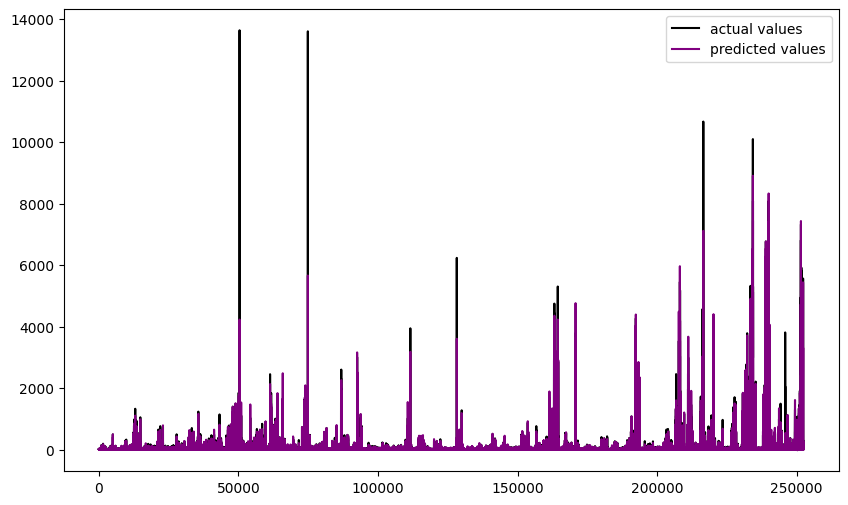

In [131]:
plot_predictions(y_test_m2, y_hat_xgb_m2)

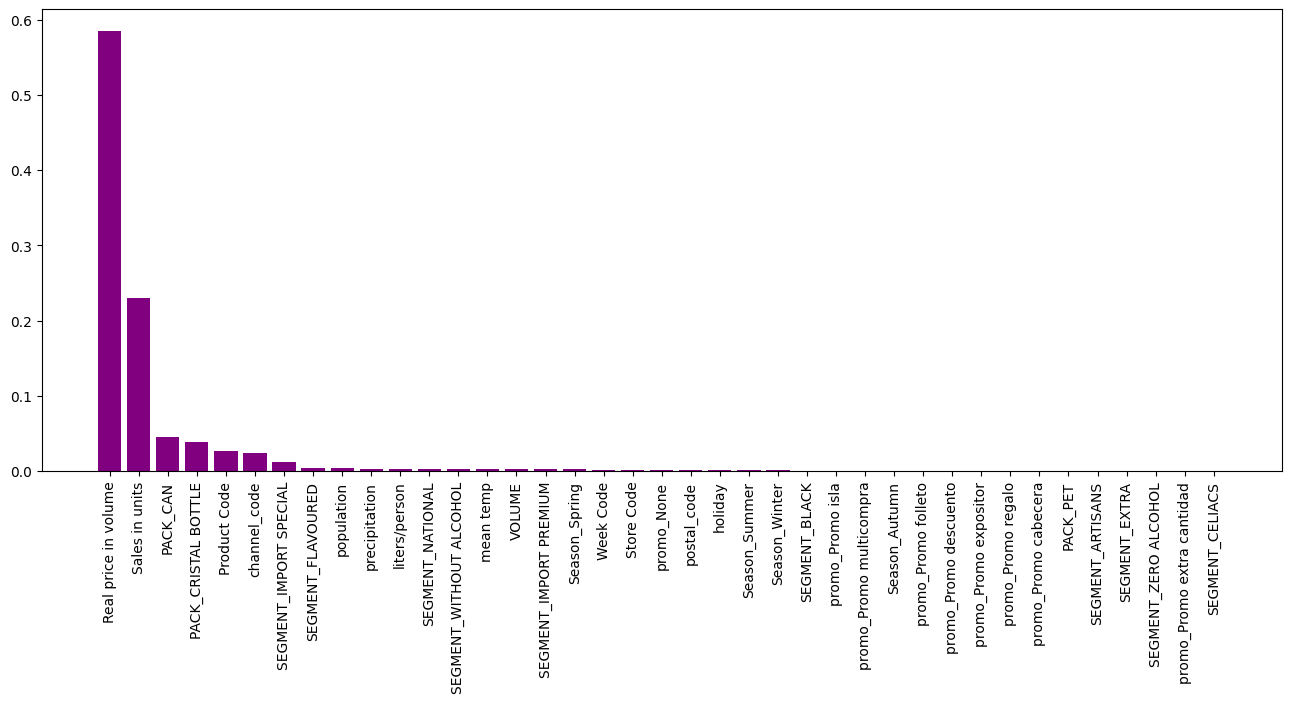

Real price in volume: 0.5847089290618896
Sales in units: 0.22933052480220795
PACK_CAN: 0.04475172981619835
PACK_CRISTAL BOTTLE: 0.038171928375959396
Product Code: 0.027102908119559288
channel_code: 0.02403312735259533
SEGMENT_IMPORT SPECIAL: 0.012558129616081715
SEGMENT_FLAVOURED: 0.004229964222759008
population: 0.0036856047809123993
precipitation: 0.003046977100893855
liters/person: 0.0029052088502794504
SEGMENT_NATIONAL: 0.0027522409800440073
SEGMENT_WITHOUT ALCOHOL: 0.0026967888697981834
mean temp: 0.002546285279095173
VOLUME: 0.002460043877363205
SEGMENT_IMPORT PREMIUM: 0.002315901219844818
Season_Spring: 0.002057725563645363
Week Code: 0.001621231553144753
Store Code: 0.0012208340922370553
promo_None: 0.0011939199175685644
postal_code: 0.0011308977846056223
holiday: 0.0009575727162882686
Season_Summer: 0.0008036836516112089
Season_Winter: 0.0007688498590141535
SEGMENT_BLACK: 0.0006415327079594135
promo_Promo isla: 0.0006178543553687632
promo_Promo multicompra: 0.00031995060271583

In [132]:
importances_m2 = xgb_model_m2.feature_importances_
sorted_importance_m2 = run_feature_importances(importances_m2, X_train_m2.columns)


In [133]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_m2.values,
                                                    mode='regression',
                                                    feature_names=X_train_m2.columns.values,
                                                    categorical_names=feature_names,
                                                    discretize_continuous=True)
exp = explainer.explain_instance(X_test_m2.values[0], xgb_model_m2.predict, num_features=X_test_m2.shape[1])
print(exp.as_list())


[('Real price in volume <= 0.33', -195.8061450677644), ('12.00 < Sales in units <= 38.00', -158.8720994307831), ('promo_Promo regalo <= 0.00', 56.939130435061244), ('SEGMENT_BLACK <= 0.00', -51.89719948704352), ('Season_Autumn <= 0.00', -46.01502017261078), ('158.00 < Store Code <= 282.00', 41.762944396234566), ('0.00 < PACK_CAN <= 1.00', -41.32261015742919), ('SEGMENT_WITHOUT ALCOHOL <= 0.00', 38.31733188618115), ('SEGMENT_IMPORT SPECIAL <= 0.00', -37.39731586801939), ('0.00 < promo_None <= 1.00', 32.3878346923872), ('Week Code > 72.00', -31.6186919961807), ('SEGMENT_EXTRA > 0.00', -26.061443555464397), ('PACK_PET <= 0.00', 24.607994388572383), ('promo_Promo expositor <= 0.00', -24.15372606035452), ('promo_Promo multicompra <= 0.00', 22.30550453681306), ('holiday <= 0.00', -21.50053501195211), ('channel_code <= 1.00', -21.159015915397035), ('promo_Promo extra cantidad <= 0.00', -17.323077778338046), ('PACK_CRISTAL BOTTLE <= 0.00', -16.295540916086985), ('liters/person <= 3.34', 15.986

## <span style="color: purple">6.3. Manufacturer 6: Drivers for sales</span> <a class="anchor" id="section_6_3"></a>

In [134]:
circana_m6 = circana[circana['Manuf_MANUFACTURER 6'] == 1]

In [135]:
circana_m6.head()

Store Code  Week Code  Product Code  Sales in units  \
730063         243         42           758              19   
730064         243        108           758              27   
730065         243         68           758              26   
730066         243         49           758              25   
730067         243         22           758              64   

        Sales in value (€)  Real price in volume  channel_code  postal_code  \
730063                6.65                  0.33             1        26003   
730064                9.45                  0.33             1        26003   
730065                9.10                  0.33             1        26003   
730066                8.75                  0.33             1        26003   
730067               22.40                  0.33             1        26003   

        VOLUME  mean temp  precipitation  holiday  population  liters/person  \
730063     330   8.800000       1.285714        0      241713       1.842685   
730064     330   6.671429       1.800000        0      241713       0.358632   
730065     330  15.500000       1.771429        1      241713       1.924468   
730066     330   2.600000       0.071429        1      241713       1.842685   
730067     330  20.800000       0.185714        0      241713       1.842685   

        Season_Autumn  Season_Spring  Season_Summer  Season_Winter  \
730063              1              0              0              0   
730064              0              0              0              1   
730065              0              1              0              0   
730066              0              0              0              1   
730067              0              1              0              0   

        SEGMENT_ARTISANS  SEGMENT_BLACK  SEGMENT_CELIACS  SEGMENT_EXTRA  \
730063                 0              0                0              0   
730064                 0              0                0              0   
730065                 0              0                0              0   
730066                 0              0                0              0   
730067                 0              0                0              0   

        SEGMENT_FLAVOURED  SEGMENT_IMPORT PREMIUM  SEGMENT_IMPORT SPECIAL  \
730063                  0                       1                       0   
730064                  0                       1                       0   
730065                  0                       1                       0   
730066                  0                       1                       0   
730067                  0                       1                       0   

        SEGMENT_NATIONAL  SEGMENT_WITHOUT ALCOHOL  SEGMENT_ZERO ALCOHOL  \
730063                 0                        0                     0   
730064                 0                        0                     0   
730065                 0                        0                     0   
730066                 0                        0                     0   
730067                 0                        0                     0   

        PACK_CAN  PACK_CRISTAL BOTTLE  PACK_PET  promo_None  \
730063         1                    0         0           1   
730064         1                    0         0           1   
730065         1                    0         0           1   
730066         1                    0         0           1   
730067         1                    0         0           1   

        promo_Promo cabecera  promo_Promo descuento  promo_Promo expositor  \
730063                     0                      0                      0   
730064                     0                      0                      0   
730065                     0                      0                      0   
730066                     0                      0                      0   
730067                     0                      0                      0   

        promo_Promo extra cantidad  pro

In [136]:
#  prepare the data for splitting: x and y
# x: features, y: target

train_data = circana_m6[circana_m6['Week Code'].between(1, 93)]  # Training data with week codes 1 to 93
test_data = circana_m6[circana_m6['Week Code'].between(94, 116)]  # Test data with week codes 94 to 116

# Split the data into features (X) and target variable (y) for training and testing
X_train_m6 = train_data.drop(columns=['Sales in value (€)'])
y_train_m6 = train_data['Sales in value (€)']
X_test_m6 = test_data.drop(columns=['Sales in value (€)'])
y_test_m6 = test_data['Sales in value (€)']

In [137]:
X_test_m6 = X_test_m6.drop(['Manuf_MANUFACTURER 1', 'Manuf_MANUFACTURER 2','Manuf_MANUFACTURER 3','Manuf_MANUFACTURER 4','Manuf_MANUFACTURER 5','Manuf_MANUFACTURER 6','Manuf_OTHER MANUFACTURERS',], axis=1)
X_train_m6 = X_train_m6.drop(['Manuf_MANUFACTURER 1', 'Manuf_MANUFACTURER 2','Manuf_MANUFACTURER 3','Manuf_MANUFACTURER 4','Manuf_MANUFACTURER 5','Manuf_MANUFACTURER 6','Manuf_OTHER MANUFACTURERS',], axis=1)

In [138]:
y_hat_xgb_m6, xgb_model_m6 = run_xgb_model( X_train_m6, y_train_m6, X_test_m6, y_test_m6)

Mean Squared Error: 675.873543734194
R-squared: 0.9957086472772713


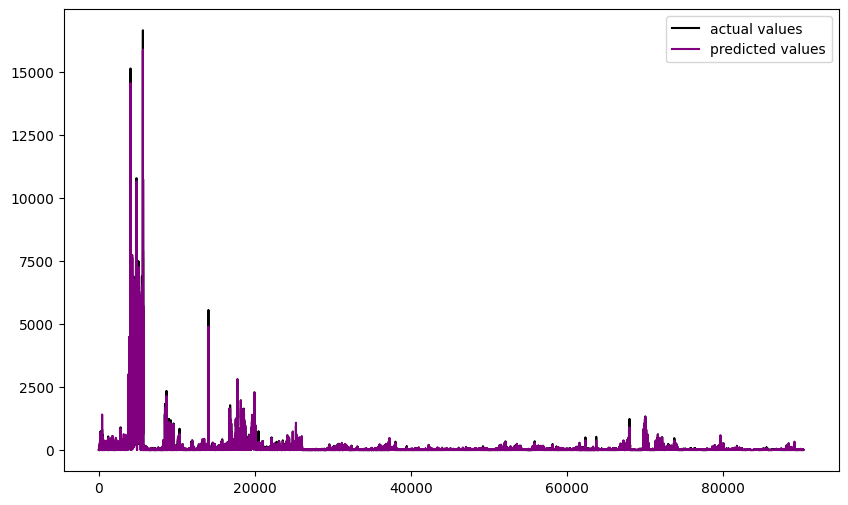

In [139]:
plot_predictions(y_test_m6, y_hat_xgb_m6)

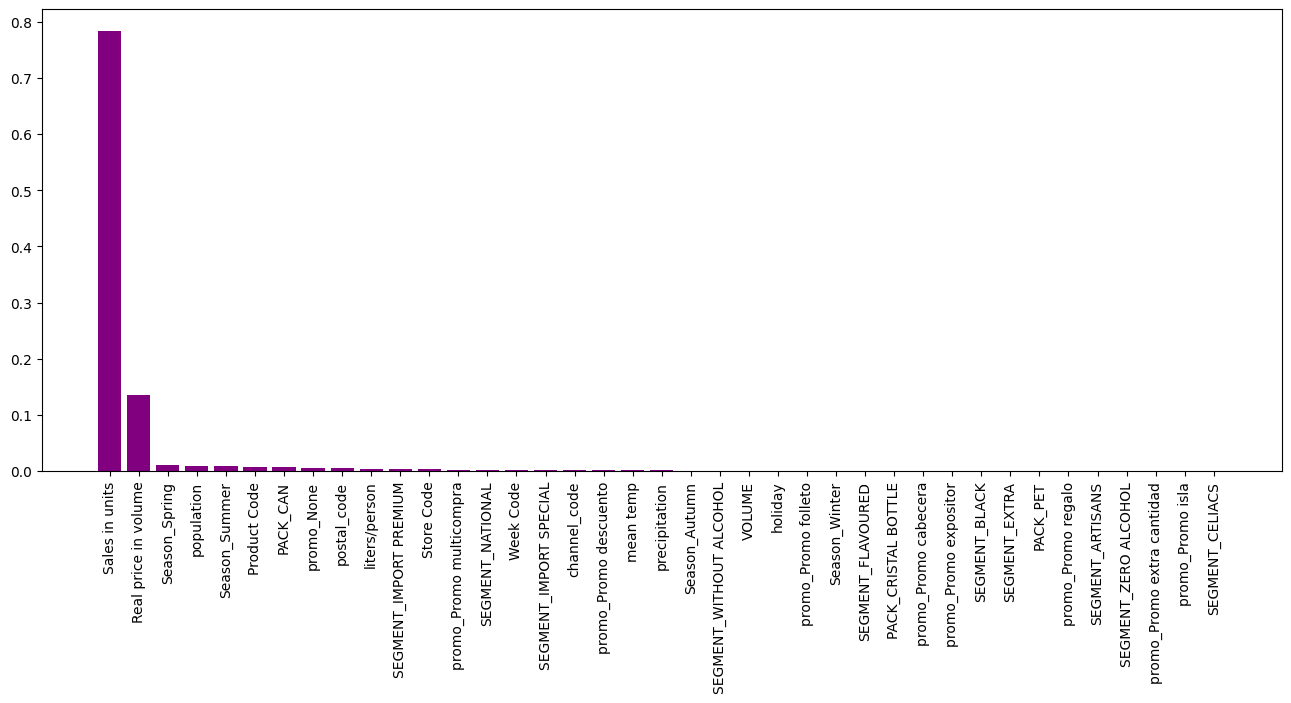

Sales in units: 0.7833362221717834
Real price in volume: 0.13510218262672424
Season_Spring: 0.010100043378770351
population: 0.009705018252134323
Season_Summer: 0.008940410800278187
Product Code: 0.006875753402709961
PACK_CAN: 0.006835073698312044
promo_None: 0.00564046623185277
postal_code: 0.005076768342405558
liters/person: 0.0037508439272642136
SEGMENT_IMPORT PREMIUM: 0.0036702214274555445
Store Code: 0.002878309693187475
promo_Promo multicompra: 0.0021586327347904444
SEGMENT_NATIONAL: 0.0021285666152834892
Week Code: 0.0020691193640232086
SEGMENT_IMPORT SPECIAL: 0.0018555219285190105
channel_code: 0.0016665317816659808
promo_Promo descuento: 0.001590901636518538
mean temp: 0.0011468994198367
precipitation: 0.0010484978556632996
Season_Autumn: 0.0009186973329633474
SEGMENT_WITHOUT ALCOHOL: 0.0006685739499516785
VOLUME: 0.0005500955739989877
holiday: 0.000526262039784342
promo_Promo folleto: 0.00038568448508158326
Season_Winter: 0.00037795453681610525
SEGMENT_FLAVOURED: 0.0002922610

{'Sales in units': 0.7833362,
 'Real price in volume': 0.13510218,
 'Season_Spring': 0.010100043,
 'population': 0.009705018,
 'Season_Summer': 0.008940411,
 'Product Code': 0.0068757534,
 'PACK_CAN': 0.0068350737,
 'promo_None': 0.005640466,
 'postal_code': 0.0050767683,
 'liters/person': 0.003750844,
 'SEGMENT_IMPORT PREMIUM': 0.0036702214,
 'Store Code': 0.0028783097,
 'promo_Promo multicompra': 0.0021586327,
 'SEGMENT_NATIONAL': 0.0021285666,
 'Week Code': 0.0020691194,
 'SEGMENT_IMPORT SPECIAL': 0.0018555219,
 'channel_code': 0.0016665318,
 'promo_Promo descuento': 0.0015909016,
 'mean temp': 0.0011468994,
 'precipitation': 0.0010484979,
 'Season_Autumn': 0.00091869733,
 'SEGMENT_WITHOUT ALCOHOL': 0.00066857395,
 'VOLUME': 0.0005500956,
 'holiday': 0.00052626204,
 'promo_Promo folleto': 0.00038568449,
 'Season_Winter': 0.00037795454,
 'SEGMENT_FLAVOURED': 0.00029226107,
 'PACK_CRISTAL BOTTLE': 0.00022277034,
 'promo_Promo cabecera': 0.00018573318,
 'promo_Promo expositor': 0.00011

In [140]:
importances_m6 = xgb_model_m6.feature_importances_
run_feature_importances(importances_m6, X_train_m6.columns)

In [141]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_m6.values,
                                                    mode='regression',
                                                    feature_names=X_train_m6.columns.values,
                                                    categorical_names=feature_names,
                                                    discretize_continuous=True)
exp = explainer.explain_instance(X_test_m6.values[0], xgb_model_m6.predict, num_features=X_test_m6.shape[1])
print(exp.as_list())


[('22.00 < Sales in units <= 81.00', -480.9927298836463), ('Real price in volume <= 0.33', -264.98673596510037), ('promo_Promo extra cantidad <= 0.00', 169.22838103004457), ('promo_Promo cabecera <= 0.00', -152.68284772949747), ('promo_Promo isla <= 0.00', 121.67850829732451), ('SEGMENT_CELIACS <= 0.00', 99.07000885572289), ('promo_Promo folleto <= 0.00', -96.42999176683809), ('promo_Promo expositor <= 0.00', 67.99666100940156), ('SEGMENT_NATIONAL <= 0.00', -61.79567247824033), ('promo_Promo descuento <= 0.00', -55.90366020304206), ('promo_Promo multicompra <= 0.00', 55.03692959836841), ('population <= 499485.00', -48.45401984471636), ('SEGMENT_BLACK <= 0.00', 42.47463373140594), ('SEGMENT_WITHOUT ALCOHOL <= 0.00', 40.35915698799327), ('0.00 < PACK_CAN <= 1.00', -40.213071143073265), ('SEGMENT_EXTRA <= 0.00', 39.44775681556895), ('146.00 < Store Code <= 271.00', 38.71938441691632), ('Season_Autumn <= 0.00', -36.15844891282691), ('PACK_CRISTAL BOTTLE <= 0.00', -25.781255823087044), ('99

## <span style="color: purple">6.4. Comparing Drivers for top 3 Manufacturers</span> <a class="anchor" id="section_6_4"></a>

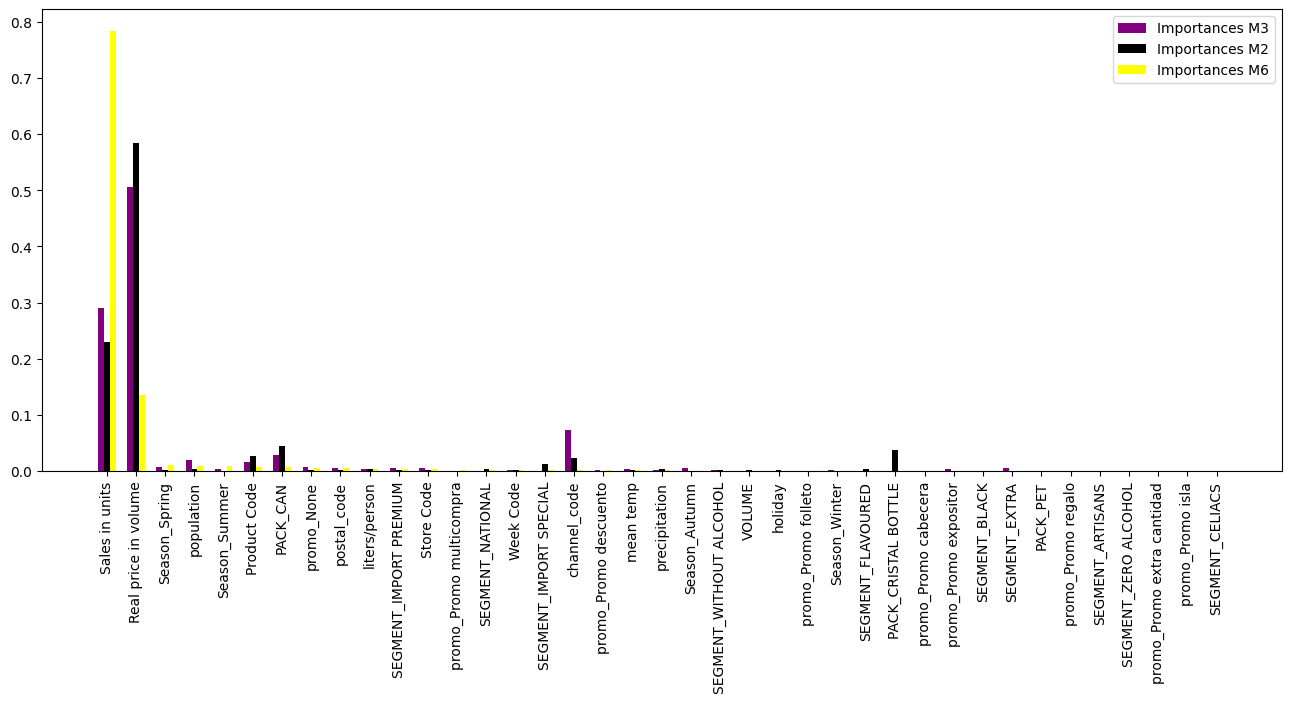

In [144]:
sorted_index_m6 = np.argsort(importances_m6)[::-1]  # Sort importances_m6 in descending order
sorted_importances_m6 = importances_m6[sorted_index_m6]  # Sorted importances_m6
sorted_labels_m6 = np.array(X_train_m6.columns)[sorted_index_m6]  # Sorted feature labels

x = np.arange(len(sorted_importances_m6))
width = 0.2  # Width of each bar

fig, ax = plt.subplots(figsize=(16, 6))

# Plot importances for importances_m3
rects1 = ax.bar(x - width, importances_m3[sorted_index_m6], width, label='Importances M3', color='purple')

# Plot importances for importances_m2
rects2 = ax.bar(x, importances_m2[sorted_index_m6], width, label='Importances M2', color='black')

# Plot importances for importances_m6
rects3 = ax.bar(x + width, sorted_importances_m6, width, label='Importances M6', color='yellow')

# Set x-axis labels
ax.set_xticks(x)
ax.set_xticklabels(sorted_labels_m6, rotation=90)

# Add legend
ax.legend()

# Show the plot
plt.show()

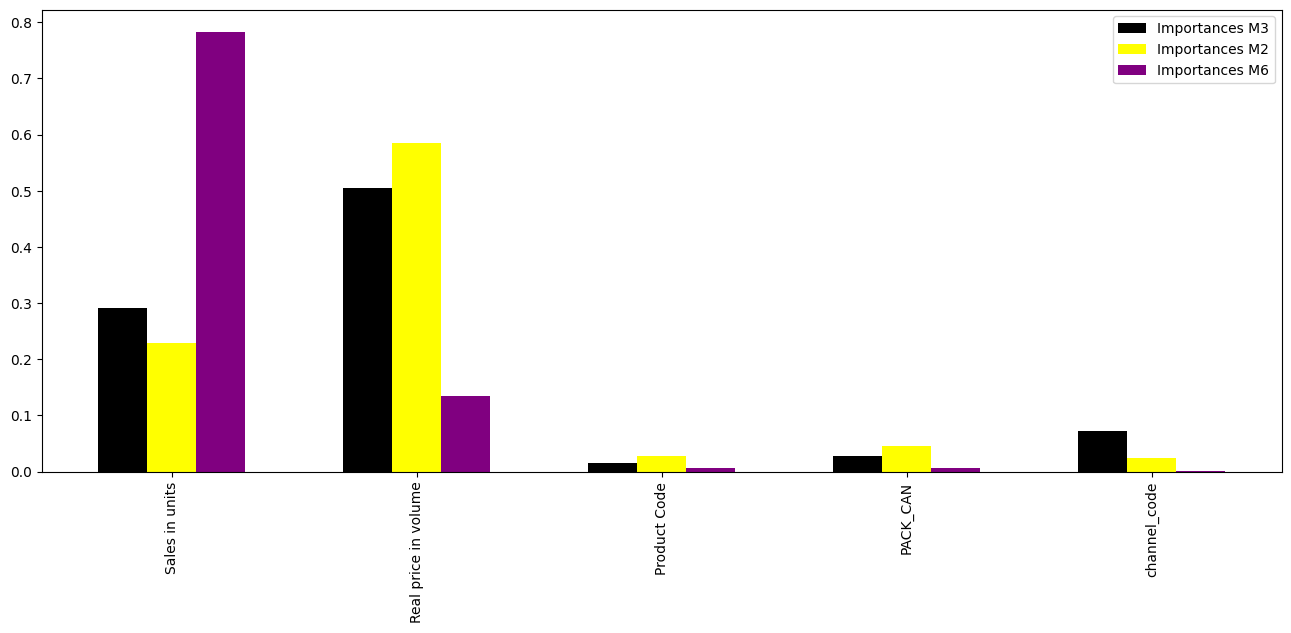

In [145]:
variables = ['Sales in units','Real price in volume', 'Product Code', 'PACK_CAN','channel_code']

# Get the sorted indices for each importance
sorted_index_m3 = np.argsort(importances_m3)[::-1]
sorted_index_m2 = np.argsort(importances_m2)[::-1]
sorted_index_m6 = np.argsort(importances_m6)[::-1]

# Get the sorted importances and labels for each importance
sorted_importances_m3 = importances_m3[sorted_index_m3]
sorted_importances_m2 = importances_m2[sorted_index_m2]
sorted_importances_m6 = importances_m6[sorted_index_m6]

sorted_labels_m3 = np.array(X_train_m3.columns)[sorted_index_m3]
sorted_labels_m2 = np.array(X_train_m2.columns)[sorted_index_m2]
sorted_labels_m6 = np.array(X_train_m6.columns)[sorted_index_m6]

# Filter the indices and importances based on the selected variables
selected_indices_m3 = [np.where(sorted_labels_m3 == variable)[0][0] for variable in variables]
selected_importances_m3 = sorted_importances_m3[selected_indices_m3]
selected_indices_m2 = [np.where(sorted_labels_m2 == variable)[0][0] for variable in variables]
selected_importances_m2 = sorted_importances_m2[selected_indices_m2]
selected_indices_m6 = [np.where(sorted_labels_m6 == variable)[0][0] for variable in variables]
selected_importances_m6 = sorted_importances_m6[selected_indices_m6]

x = np.arange(len(variables))
width = 0.2

fig, ax = plt.subplots(figsize=(16, 6))

rects_m3 = ax.bar(x - width, selected_importances_m3, width, label='Importances M3', color='black')
rects_m2 = ax.bar(x, selected_importances_m2, width, label='Importances M2', color='yellow')
rects_m6 = ax.bar(x + width, selected_importances_m6, width, label='Importances M6', color='purple')

ax.set_xticks(x)
ax.set_xticklabels(variables, rotation=90)

ax.legend()

plt.show()



In [146]:
#create a df that is a  of zip sorted_labels_m3, sorted_importances_m3
df_m3 = pd.DataFrame({'sorted_labels_m3':sorted_labels_m3, 'sorted_importances_m3':sorted_importances_m3})
df_m3


sorted_labels_m3  sorted_importances_m3
0         Real price in volume               0.505133
1               Sales in units               0.290362
2                 channel_code               0.072774
3                     PACK_CAN               0.027646
4                   population               0.020058
5                 Product Code               0.016028
6                Season_Spring               0.007654
7                   promo_None               0.007269
8                   Store Code               0.006082
9       SEGMENT_IMPORT PREMIUM               0.005570
10                 postal_code               0.005388
11               SEGMENT_EXTRA               0.005198
12               Season_Autumn               0.004692
13                   mean temp               0.004096
14               Season_Summer               0.003419
15               liters/person               0.003299
16       promo_Promo expositor               0.003255
17     SEGMENT_WITHOUT ALCOHOL               0.002071
18                   Week Code               0.001298
19               precipitation               0.001152
20               Season_Winter               0.001118
21       promo_Promo descuento               0.001070
22     promo_Promo multicompra               0.000746
23      SEGMENT_IMPORT SPECIAL               0.000722
24            promo_Promo isla               0.000687
25          promo_Promo regalo               0.000674
26                      VOLUME               0.000618
27         promo_Promo folleto               0.000404
28                     holiday               0.000362
29        promo_Promo cabecera               0.000315
30           SEGMENT_FLAVOURED               0.000293
31            SEGMENT_NATIONAL               0.000250
32             SEGMENT_CELIACS               0.000190
33  promo_Promo extra cantidad               0.000046
34         PACK_CRISTAL BOTTLE               0.000043
35               SEGMENT_BLACK               0.000018
36            SEGMENT_ARTISANS               0.000000
37        SEGMENT_ZERO ALCOHOL               0.000000
38                    PACK_PET               0.000000

In [147]:
df_m2 = pd.DataFrame({'sorted_labels_m2':sorted_labels_m2, 'sorted_importances_m2':sorted_importances_m2})
df_m2

sorted_labels_m2  sorted_importances_m2
0         Real price in volume               0.584709
1               Sales in units               0.229331
2                     PACK_CAN               0.044752
3          PACK_CRISTAL BOTTLE               0.038172
4                 Product Code               0.027103
5                 channel_code               0.024033
6       SEGMENT_IMPORT SPECIAL               0.012558
7            SEGMENT_FLAVOURED               0.004230
8                   population               0.003686
9                precipitation               0.003047
10               liters/person               0.002905
11            SEGMENT_NATIONAL               0.002752
12     SEGMENT_WITHOUT ALCOHOL               0.002697
13                   mean temp               0.002546
14                      VOLUME               0.002460
15      SEGMENT_IMPORT PREMIUM               0.002316
16               Season_Spring               0.002058
17                   Week Code               0.001621
18                  Store Code               0.001221
19                  promo_None               0.001194
20                 postal_code               0.001131
21                     holiday               0.000958
22               Season_Summer               0.000804
23               Season_Winter               0.000769
24               SEGMENT_BLACK               0.000642
25            promo_Promo isla               0.000618
26     promo_Promo multicompra               0.000320
27               Season_Autumn               0.000316
28         promo_Promo folleto               0.000312
29       promo_Promo descuento               0.000293
30       promo_Promo expositor               0.000187
31          promo_Promo regalo               0.000145
32        promo_Promo cabecera               0.000104
33                    PACK_PET               0.000013
34            SEGMENT_ARTISANS               0.000000
35               SEGMENT_EXTRA               0.000000
36        SEGMENT_ZERO ALCOHOL               0.000000
37  promo_Promo extra cantidad               0.000000
38             SEGMENT_CELIACS               0.000000

In [148]:
df_m6 = pd.DataFrame({'sorted_labels_m6':sorted_labels_m6, 'sorted_importances_m6':sorted_importances_m6})
df_m6

sorted_labels_m6  sorted_importances_m6
0               Sales in units               0.783336
1         Real price in volume               0.135102
2                Season_Spring               0.010100
3                   population               0.009705
4                Season_Summer               0.008940
5                 Product Code               0.006876
6                     PACK_CAN               0.006835
7                   promo_None               0.005640
8                  postal_code               0.005077
9                liters/person               0.003751
10      SEGMENT_IMPORT PREMIUM               0.003670
11                  Store Code               0.002878
12     promo_Promo multicompra               0.002159
13            SEGMENT_NATIONAL               0.002129
14                   Week Code               0.002069
15      SEGMENT_IMPORT SPECIAL               0.001856
16                channel_code               0.001667
17       promo_Promo descuento               0.001591
18                   mean temp               0.001147
19               precipitation               0.001048
20               Season_Autumn               0.000919
21     SEGMENT_WITHOUT ALCOHOL               0.000669
22                      VOLUME               0.000550
23                     holiday               0.000526
24         promo_Promo folleto               0.000386
25               Season_Winter               0.000378
26           SEGMENT_FLAVOURED               0.000292
27         PACK_CRISTAL BOTTLE               0.000223
28        promo_Promo cabecera               0.000186
29       promo_Promo expositor               0.000115
30               SEGMENT_BLACK               0.000100
31               SEGMENT_EXTRA               0.000030
32                    PACK_PET               0.000028
33          promo_Promo regalo               0.000024
34            SEGMENT_ARTISANS               0.000000
35        SEGMENT_ZERO ALCOHOL               0.000000
36  promo_Promo extra cantidad               0.000000
37            promo_Promo isla               0.000000
38             SEGMENT_CELIACS               0.000000